#  **Colab File for 2D-CNN training for Classification - PyTorch**
Before you start please prepare the following:


1.   Uplaod the dataset as Zip file to GDrive
2.   Upload code files to GDrive



# **Install and Import Required Libraries**
Use 'pip' to install libraries. Put '!' i.e. Exclamation Mark before each command, exclusive to Jupyter Notebooks. Some are already installed by Google Colab and others are required. If the IMPORT statements are present in the python code being run, no need to follow this step.

Install or Update Libraries

In [ ]:
# !pip install torch==1.11.0 torchvision==0.12.0 torchaudio
# !pip install torchvision
# !pip install torchsummary
%pip install numpy
%pip install pandas
%pip install scikit-learn
%pip install scikit-image
%pip install ipython
%pip install Pillow
%pip install matplotlib
%pip install seaborn
%pip install timm
%pip install opencv-python
%pip install glob2
%pip install timm
%pip install torchsummary

In [ ]:
%pip install chardet

In [ ]:
%pip install torch==2.1.1 torchvision==0.16.1 torchaudio==2.1.1 --index-url https://download.pytorch.org/whl/cu121

Import Libraries

In [1]:
import cv2
import numpy as np
import torch
import os
import warnings
import torch.nn as nn
import torch
import random
import shutil
import configparser
import matplotlib.pyplot as plt
from importlib import import_module
from os import path
from tqdm import tqdm
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
warnings.filterwarnings('ignore', category=FutureWarning)
plt.rcParams['font.size'] = 14

# **Check GPU Status**
Check the available GPU from the Google Server, GPU model and other related information.

**Please MAKE sure that you are using GPU . Go to Runtime>> Change Runtime type  and select GPU**

In [2]:
print("Is CUDA enabled GPU Available?", torch.cuda.is_available())
print("Is GPU Initialized yet?", torch.cuda.is_initialized())
print("GPU Number:", torch.cuda.device_count())
print("Current GPU Index:", torch.cuda.current_device())
print("GPU Type:", torch.cuda.get_device_name(device=None))
print("GPU Capability:", torch.cuda.get_device_capability(device=None))

Is CUDA enabled GPU Available? True
Is GPU Initialized yet? False
GPU Number: 1
Current GPU Index: 0
GPU Type: NVIDIA GeForce RTX 3080 Ti Laptop GPU
GPU Capability: (8, 6)


# **Import and Prepare Code and Dataset files** 
1- Copy dataset file and codes to your Google Colab instance (Change file names if necessary ), dont have to copy the data files to the content here, as it will be copied in the next code

In [3]:
def copyimagefile(source_path, destination_path, files_list):
    for order in range(1, len(files_list)):
        files = files_list[order]
        shutil.copyfile(os.path.join(source_path, files),
                        os.path.join(destination_path, files))


In [4]:
def create_folds(raw_data_path, num_folds, train_portion, validation_portion=False):
    Class_Names = os.listdir(raw_data_path)
    for i in range(1, num_folds + 1):
        print(f'Creating Fold {i}')
        for ii in tqdm(range(0, len(Class_Names))):
            # Get Train and Test Image Indices Randomly for each Fold
            source_path = f'{raw_data_path}/{Class_Names[ii]}'
            X_Tot = os.listdir(source_path)  # List containing all images
            X_Train_Len = int(len(X_Tot) * train_portion)
            # Randomly formed List containing images for training, can be stratified otherwise
            X_Train = random.sample(X_Tot, (X_Train_Len - 1))
            # List containing images for testing
            X_Test = [x for x in X_Tot if x not in X_Train]
            X_Val = []
            if validation_portion:
                # Size of the Validation Set, subset of the Training Set
                X_Val_Len = int(len(X_Train) * validation_portion)
                X_Val = random.sample(
                    X_Train, (X_Val_Len - 1))  # Validation Set
                # Validation Set is deducted from the Training Set
                X_Train = [x for x in X_Train if x not in X_Val]

            # Make Required Directories after Checking their Existence, sometimes delete old folders and run the code again
            train_dir = f'Data/Train/fold_{i}/{Class_Names[ii]}'
            test_dir = f'Data/Test/fold_{i}/{Class_Names[ii]}'
            val_dir = f'Data/Val/fold_{i}/{Class_Names[ii]}'
            if not os.path.isdir(train_dir):
                os.makedirs(train_dir)  # Train Directory for Fold ii
            if not os.path.isdir(test_dir):
                os.makedirs(test_dir)  # Test Directory for Fold ii
            if (not os.path.isdir(val_dir)) and (validation_portion != False):
                os.makedirs(val_dir)  # Validation Directory for Fold ii

            # Copy Image Files from the Source Folder to the Destination Folder
            copyimagefile(source_path, train_dir, X_Train)
            copyimagefile(source_path, test_dir, X_Test)
            if validation_portion:
                # True if validation set is created independently
                copyimagefile(source_path, val_dir, X_Val)


In [30]:
raw_data_path = 'UCI_32'
num_folds = 5
train_portion = 0.8  # test_portion = 1 - train_portion
val_portion = 0.1  # validation data is part of the train set
create_folds(raw_data_path, num_folds, train_portion,
             validation_portion=val_portion)


Creating Fold 1


100%|██████████| 2/2 [01:44<00:00, 52.35s/it]


Creating Fold 2


100%|██████████| 2/2 [00:54<00:00, 27.11s/it]


Creating Fold 3


100%|██████████| 2/2 [01:01<00:00, 30.54s/it]


Creating Fold 4


100%|██████████| 2/2 [01:03<00:00, 31.98s/it]


Creating Fold 5


100%|██████████| 2/2 [01:02<00:00, 31.26s/it]


# **MAIN**



## **Train**

Training Configurations

In [3]:
%%writefile config_train.py
# CNN train configuration file 
config = {}
config['parentdir'] = ''                      # root directory
config['isPretrained'] = True                         # set to 'True' to use pretrained weights or set to 'False' to train from scratch
config['model_mode'] = 'import_TIMM'                   # 'custom_CNN' | 'custom_ONN' | 'import_Torch' | 'import_TIMM'
config['q_order'] = 3                                  # qth order Maclaurin approximation, common values: {1,3,5,7,9}. q=1 is equivalent to conventional CNN
config['ONN'] = False                                  # set to 'True' if you are using ONN
config['input_ch'] = 3                                 # 1 for gray scale x-rays, and 3 for RGB (3channel) x-rays  
config['batch_size'] = 4                               # Batch size, Change to fit hardware, common values: {4,8,16} for 2D datasets
# config['input_mean'] = [0.2936]                      # Dataset mean per channel, b/w [0,1]
# config['input_std'] = [0.1895]                       # Dataset std per channel,  b/w [0,1]
config['input_mean'] = [0.0609,0.0609,0.0609]          # Dataset mean per channel, RGB or RGBA [0,1]
config['input_std'] = [0.1540,0.1540,0.1540]           # Dataset std per channel,  RGB or RGBA [0,1]
config['loss_func'] = 'CrossEntropyLoss'                        # 'MSELoss', 'CrossEntropyLoss', etc. (https://pytorch.org/docs/stable/nn.html)
config['optim_fc'] = 'Adam'                            # 'Adam', 'SGD', etc. (https://pytorch.org/docs/stable/optim.html)
config['optim_scheduler'] = 'ReduceLROnPlateau'        # 'ReduceLROnPlateau', etc. (https://pytorch.org/docs/stable/optim.html)
config['final_activation_func'] = 'Sigmoid'         # 'Sigmoid', 'Softmax', etc. (https://pytorch.org/docs/stable/nn.html)
config['lr'] = 0.0002                                  # learning rate 
config['stop_criteria'] = 'accuracy'                   # Stopping criteria: 'loss' or 'accuracy'
config['n_epochs'] = 300                               # Number of training epochs
config['epochs_patience'] = 10                         # If val loss did not decrease for a number of epochs then decrease learning rate by a factor of lr_factor
config['lr_factor'] = 0.1                              # Learning factor
config['max_epochs_stop'] = 30                         # Maximum number of epochs with no improvement in validation loss for early stopping
config['num_folds'] = 1                                # Number of cross-validation folds
config['Resize_h'] = 224                               # Network input (Image) height
config['Resize_w'] = config['Resize_h']                # Network input (Image) width
config['load_weights'] = None                      # Default: False, comment it out and Specify path of pretrained model weights above to make it True  
# config['load_weights'] = config['parentdir'] + 'Checkpoint_1.pt' # specify path of pretrained model weights or set to False to train from scratch
config['aux_logits'] = False                  # Required for models with auxilliary outputs (e.g., InceptionV3)     
config['model_to_load'] = 'convnext_xlarge.fb_in22k_ft_in1k'                # Choose one of the models specified in config file
config['model_name'] = 'convnext_xlarge_AHN_Classification'  # Choose a unique name for result folder            
config['encoder'] = False                              # Set to 'True' if you retrain Seg. model encoder as a classifer 
config['fold_to_run'] = [1,5]                          # Define as [] to loop through all folds, or specify start and end folds i.e. [3,5] or [5,5]
config['outdir'] = ''


Overwriting config_train.py


Start Training

Train on GPU: True
1 GPUs detected.
Training using convnext_xlarge.fb_in22k_ft_in1k network
Starting Fold 1...


Model device: CUDA
Starting Training...



Epoch 0: 100%|██████████| 522/522 [02:50<00:00,  3.05it/s, accuracy=0.75, loss=0.881]


Training Loss: 0.6300 	Validation Loss: 0.2770 	Test Loss: 0.5306
Training Accuracy: 75.73% 	Validation Accuracy: 91.49% 	Test Accuracy: 82.00%



Epoch 1: 100%|██████████| 522/522 [02:42<00:00,  3.21it/s, accuracy=1, loss=0.102]   


Training Loss: 0.2723 	Validation Loss: 0.3935 	Test Loss: 0.5759
Training Accuracy: 90.47% 	Validation Accuracy: 84.40% 	Test Accuracy: 80.00%



Epoch 2: 100%|██████████| 522/522 [02:43<00:00,  3.20it/s, accuracy=1, loss=0.0737]  


Training Loss: 0.1583 	Validation Loss: 0.6152 	Test Loss: 0.9690
Training Accuracy: 94.69% 	Validation Accuracy: 85.82% 	Test Accuracy: 74.67%



Epoch 3: 100%|██████████| 522/522 [02:43<00:00,  3.19it/s, accuracy=1, loss=0.0114]  


Training Loss: 0.1104 	Validation Loss: 0.4162 	Test Loss: 0.7427
Training Accuracy: 96.55% 	Validation Accuracy: 84.40% 	Test Accuracy: 78.67%



Epoch 4: 100%|██████████| 522/522 [02:43<00:00,  3.18it/s, accuracy=1, loss=0.0266]  


Training Loss: 0.0995 	Validation Loss: 0.4332 	Test Loss: 1.3269
Training Accuracy: 96.84% 	Validation Accuracy: 92.20% 	Test Accuracy: 79.67%



Epoch 5: 100%|██████████| 522/522 [02:43<00:00,  3.18it/s, accuracy=1, loss=0.096]   


Training Loss: 0.1303 	Validation Loss: 0.4913 	Test Loss: 0.7934
Training Accuracy: 96.07% 	Validation Accuracy: 85.82% 	Test Accuracy: 76.33%



Epoch 6: 100%|██████████| 522/522 [02:44<00:00,  3.18it/s, accuracy=1, loss=0.0631]  


Training Loss: 0.0505 	Validation Loss: 0.2955 	Test Loss: 0.6447
Training Accuracy: 98.66% 	Validation Accuracy: 88.65% 	Test Accuracy: 79.33%



Epoch 7: 100%|██████████| 522/522 [02:43<00:00,  3.19it/s, accuracy=1, loss=0.02]    


Training Loss: 0.0835 	Validation Loss: 0.5102 	Test Loss: 1.1742
Training Accuracy: 97.51% 	Validation Accuracy: 90.78% 	Test Accuracy: 78.00%



Epoch 8: 100%|██████████| 522/522 [02:44<00:00,  3.18it/s, accuracy=1, loss=0.000711]


Training Loss: 0.0540 	Validation Loss: 0.4367 	Test Loss: 0.9491
Training Accuracy: 98.32% 	Validation Accuracy: 92.20% 	Test Accuracy: 80.33%



Epoch 9: 100%|██████████| 522/522 [03:04<00:00,  2.84it/s, accuracy=1, loss=0.00434] 


Training Loss: 0.0897 	Validation Loss: 0.5223 	Test Loss: 0.9020
Training Accuracy: 97.32% 	Validation Accuracy: 88.65% 	Test Accuracy: 78.67%



Epoch 10: 100%|██████████| 522/522 [05:31<00:00,  1.57it/s, accuracy=1, loss=0.00271] 


Training Loss: 0.0582 	Validation Loss: 0.4513 	Test Loss: 1.0698
Training Accuracy: 98.28% 	Validation Accuracy: 90.78% 	Test Accuracy: 79.67%



Epoch 11: 100%|██████████| 522/522 [05:30<00:00,  1.58it/s, accuracy=1, loss=0.000698]


Training Loss: 0.0408 	Validation Loss: 0.6330 	Test Loss: 1.3583
Training Accuracy: 98.71% 	Validation Accuracy: 87.23% 	Test Accuracy: 72.00%

Epoch 00012: reducing learning rate of group 0 to 2.0000e-05.


Epoch 12: 100%|██████████| 522/522 [05:30<00:00,  1.58it/s, accuracy=1, loss=0.0031]  


Training Loss: 0.0055 	Validation Loss: 0.5982 	Test Loss: 1.3032
Training Accuracy: 99.76% 	Validation Accuracy: 90.78% 	Test Accuracy: 77.33%



Epoch 13: 100%|██████████| 522/522 [05:24<00:00,  1.61it/s, accuracy=1, loss=0.0053]  


Training Loss: 0.0011 	Validation Loss: 0.6043 	Test Loss: 1.3500
Training Accuracy: 99.95% 	Validation Accuracy: 90.78% 	Test Accuracy: 76.67%



Epoch 14: 100%|██████████| 522/522 [05:17<00:00,  1.64it/s, accuracy=1, loss=9.69e-5] 


Training Loss: 0.0007 	Validation Loss: 0.6093 	Test Loss: 1.3702
Training Accuracy: 99.95% 	Validation Accuracy: 92.20% 	Test Accuracy: 77.00%



Epoch 15: 100%|██████████| 522/522 [05:15<00:00,  1.66it/s, accuracy=1, loss=3.27e-5] 


Training Loss: 0.0006 	Validation Loss: 0.6152 	Test Loss: 1.3834
Training Accuracy: 99.95% 	Validation Accuracy: 92.20% 	Test Accuracy: 77.00%



Epoch 16: 100%|██████████| 522/522 [05:09<00:00,  1.69it/s, accuracy=1, loss=5.38e-5] 


Training Loss: 0.0005 	Validation Loss: 0.6210 	Test Loss: 1.3939
Training Accuracy: 99.95% 	Validation Accuracy: 91.49% 	Test Accuracy: 77.33%



Epoch 17: 100%|██████████| 522/522 [05:07<00:00,  1.70it/s, accuracy=1, loss=0.00175] 


Training Loss: 0.0005 	Validation Loss: 0.6286 	Test Loss: 1.4209
Training Accuracy: 99.95% 	Validation Accuracy: 91.49% 	Test Accuracy: 77.00%



Epoch 18: 100%|██████████| 522/522 [05:15<00:00,  1.65it/s, accuracy=1, loss=9.69e-5] 


Training Loss: 0.0003 	Validation Loss: 0.6389 	Test Loss: 1.4419
Training Accuracy: 99.95% 	Validation Accuracy: 91.49% 	Test Accuracy: 77.00%



Epoch 19: 100%|██████████| 522/522 [05:12<00:00,  1.67it/s, accuracy=1, loss=3.21e-5] 


Training Loss: 0.0003 	Validation Loss: 0.6729 	Test Loss: 1.5408
Training Accuracy: 99.95% 	Validation Accuracy: 91.49% 	Test Accuracy: 77.33%



Epoch 20: 100%|██████████| 522/522 [05:12<00:00,  1.67it/s, accuracy=1, loss=4.89e-6] 


Training Loss: 0.0002 	Validation Loss: 0.6753 	Test Loss: 1.5591
Training Accuracy: 99.95% 	Validation Accuracy: 91.49% 	Test Accuracy: 77.67%



Epoch 21: 100%|██████████| 522/522 [05:07<00:00,  1.70it/s, accuracy=1, loss=5.29e-5] 


Training Loss: 0.0001 	Validation Loss: 0.7316 	Test Loss: 1.6679
Training Accuracy: 99.95% 	Validation Accuracy: 92.20% 	Test Accuracy: 78.00%



Epoch 22: 100%|██████████| 522/522 [05:07<00:00,  1.70it/s, accuracy=1, loss=7e-6]    


Training Loss: 0.0001 	Validation Loss: 0.8765 	Test Loss: 2.0088
Training Accuracy: 99.95% 	Validation Accuracy: 90.78% 	Test Accuracy: 77.67%

Epoch 00023: reducing learning rate of group 0 to 2.0000e-06.


Epoch 23: 100%|██████████| 522/522 [05:05<00:00,  1.71it/s, accuracy=1, loss=3.46e-6] 


Training Loss: 0.0000 	Validation Loss: 0.8607 	Test Loss: 1.9350
Training Accuracy: 99.95% 	Validation Accuracy: 91.49% 	Test Accuracy: 78.33%



Epoch 24: 100%|██████████| 522/522 [05:10<00:00,  1.68it/s, accuracy=1, loss=4.29e-6] 


Training Loss: 0.0000 	Validation Loss: 0.8295 	Test Loss: 1.8556
Training Accuracy: 99.95% 	Validation Accuracy: 92.20% 	Test Accuracy: 78.33%



Epoch 25: 100%|██████████| 522/522 [05:08<00:00,  1.69it/s, accuracy=1, loss=1.64e-5] 


Training Loss: 0.0001 	Validation Loss: 0.8379 	Test Loss: 1.8664
Training Accuracy: 99.95% 	Validation Accuracy: 92.20% 	Test Accuracy: 78.33%



Epoch 26: 100%|██████████| 522/522 [05:00<00:00,  1.74it/s, accuracy=1, loss=1.44e-5] 


Training Loss: 0.0001 	Validation Loss: 0.8442 	Test Loss: 1.8725
Training Accuracy: 99.95% 	Validation Accuracy: 91.49% 	Test Accuracy: 78.67%



Epoch 27: 100%|██████████| 522/522 [05:01<00:00,  1.73it/s, accuracy=1, loss=0.000182]


Training Loss: 0.0001 	Validation Loss: 0.8457 	Test Loss: 1.8702
Training Accuracy: 99.95% 	Validation Accuracy: 91.49% 	Test Accuracy: 78.67%



Epoch 28: 100%|██████████| 522/522 [05:02<00:00,  1.72it/s, accuracy=1, loss=2.38e-6] 


Training Loss: 0.0001 	Validation Loss: 0.8486 	Test Loss: 1.8747
Training Accuracy: 99.95% 	Validation Accuracy: 92.20% 	Test Accuracy: 78.67%



Epoch 29: 100%|██████████| 522/522 [05:07<00:00,  1.70it/s, accuracy=1, loss=2.38e-7] 


Training Loss: 0.0001 	Validation Loss: 0.9068 	Test Loss: 1.9931
Training Accuracy: 99.95% 	Validation Accuracy: 91.49% 	Test Accuracy: 79.00%



Epoch 30: 100%|██████████| 522/522 [04:59<00:00,  1.74it/s, accuracy=1, loss=1.73e-6] 


Training Loss: 0.0001 	Validation Loss: 0.9277 	Test Loss: 1.9976
Training Accuracy: 99.95% 	Validation Accuracy: 92.20% 	Test Accuracy: 79.00%


Early Stopping! Total epochs: 30. Best epoch: 0 with loss: 0.53 and acc: 82.00%
8999.61 total seconds elapsed. 290.31 seconds per epoch.
Test Loss: 0.5306,  Test Accuracy: 82.0%
Completed fold 1
Starting Fold 2...
Model device: CUDA
Starting Training...



Epoch 0: 100%|██████████| 569/569 [05:47<00:00,  1.64it/s, accuracy=0.75, loss=0.326]


Training Loss: 0.6824 	Validation Loss: 0.2903 	Test Loss: 0.3481
Training Accuracy: 72.89% 	Validation Accuracy: 91.45% 	Test Accuracy: 87.56%



Epoch 1: 100%|██████████| 569/569 [05:20<00:00,  1.78it/s, accuracy=0.75, loss=1.03] 


Training Loss: 0.3072 	Validation Loss: 0.3740 	Test Loss: 0.7127
Training Accuracy: 88.80% 	Validation Accuracy: 89.47% 	Test Accuracy: 81.78%



Epoch 2: 100%|██████████| 569/569 [05:38<00:00,  1.68it/s, accuracy=1, loss=0.0146]  


Training Loss: 0.1888 	Validation Loss: 0.3699 	Test Loss: 0.4384
Training Accuracy: 93.76% 	Validation Accuracy: 92.11% 	Test Accuracy: 86.67%



Epoch 3: 100%|██████████| 569/569 [05:36<00:00,  1.69it/s, accuracy=1, loss=0.000833]


Training Loss: 0.1130 	Validation Loss: 0.3372 	Test Loss: 0.4548
Training Accuracy: 96.40% 	Validation Accuracy: 92.76% 	Test Accuracy: 87.56%



Epoch 4: 100%|██████████| 569/569 [05:35<00:00,  1.69it/s, accuracy=0.5, loss=1.17]  


Training Loss: 0.1772 	Validation Loss: 0.3796 	Test Loss: 0.5908
Training Accuracy: 95.08% 	Validation Accuracy: 89.47% 	Test Accuracy: 78.67%



Epoch 5: 100%|██████████| 569/569 [05:40<00:00,  1.67it/s, accuracy=0.75, loss=1.7]  


Training Loss: 0.0748 	Validation Loss: 0.5264 	Test Loss: 0.8213
Training Accuracy: 97.19% 	Validation Accuracy: 85.53% 	Test Accuracy: 82.22%



Epoch 6: 100%|██████████| 569/569 [05:46<00:00,  1.64it/s, accuracy=1, loss=0.00922] 


Training Loss: 0.0878 	Validation Loss: 0.7801 	Test Loss: 1.4785
Training Accuracy: 97.58% 	Validation Accuracy: 73.68% 	Test Accuracy: 64.00%



Epoch 7: 100%|██████████| 569/569 [05:36<00:00,  1.69it/s, accuracy=1, loss=0.0014]  


Training Loss: 0.0869 	Validation Loss: 0.3080 	Test Loss: 0.3564
Training Accuracy: 97.28% 	Validation Accuracy: 92.11% 	Test Accuracy: 85.33%



Epoch 8: 100%|██████████| 569/569 [05:47<00:00,  1.64it/s, accuracy=1, loss=0.00872] 


Training Loss: 0.0678 	Validation Loss: 0.4090 	Test Loss: 0.5641
Training Accuracy: 98.11% 	Validation Accuracy: 90.79% 	Test Accuracy: 87.11%



Epoch 9: 100%|██████████| 569/569 [05:43<00:00,  1.66it/s, accuracy=1, loss=0.00489] 


Training Loss: 0.0832 	Validation Loss: 0.3783 	Test Loss: 0.4110
Training Accuracy: 97.50% 	Validation Accuracy: 93.42% 	Test Accuracy: 90.22%



Epoch 10: 100%|██████████| 569/569 [05:08<00:00,  1.84it/s, accuracy=1, loss=0.0118]  


Training Loss: 0.0639 	Validation Loss: 0.3035 	Test Loss: 0.3781
Training Accuracy: 98.02% 	Validation Accuracy: 92.11% 	Test Accuracy: 90.22%



Epoch 11: 100%|██████████| 569/569 [05:37<00:00,  1.68it/s, accuracy=1, loss=0.124]   


Training Loss: 0.0631 	Validation Loss: 0.3700 	Test Loss: 0.4273
Training Accuracy: 98.11% 	Validation Accuracy: 90.79% 	Test Accuracy: 87.11%

Epoch 00012: reducing learning rate of group 0 to 2.0000e-05.


Epoch 12: 100%|██████████| 569/569 [05:28<00:00,  1.73it/s, accuracy=1, loss=0.000747]


Training Loss: 0.0249 	Validation Loss: 0.4429 	Test Loss: 0.5271
Training Accuracy: 99.12% 	Validation Accuracy: 90.79% 	Test Accuracy: 86.67%



Epoch 13: 100%|██████████| 569/569 [05:42<00:00,  1.66it/s, accuracy=1, loss=0.00234] 


Training Loss: 0.0047 	Validation Loss: 0.5019 	Test Loss: 0.5725
Training Accuracy: 99.87% 	Validation Accuracy: 92.11% 	Test Accuracy: 87.11%



Epoch 14: 100%|██████████| 569/569 [05:35<00:00,  1.70it/s, accuracy=1, loss=0.00106] 


Training Loss: 0.0026 	Validation Loss: 0.4991 	Test Loss: 0.5854
Training Accuracy: 99.96% 	Validation Accuracy: 90.79% 	Test Accuracy: 87.11%



Epoch 15: 100%|██████████| 569/569 [05:29<00:00,  1.73it/s, accuracy=1, loss=0.000177]


Training Loss: 0.0019 	Validation Loss: 0.5204 	Test Loss: 0.6097
Training Accuracy: 99.96% 	Validation Accuracy: 90.79% 	Test Accuracy: 86.67%



Epoch 16: 100%|██████████| 569/569 [05:32<00:00,  1.71it/s, accuracy=1, loss=0.000186]


Training Loss: 0.0020 	Validation Loss: 0.5220 	Test Loss: 0.6052
Training Accuracy: 99.96% 	Validation Accuracy: 91.45% 	Test Accuracy: 88.00%



Epoch 17: 100%|██████████| 569/569 [05:58<00:00,  1.59it/s, accuracy=1, loss=0.000604]


Training Loss: 0.0016 	Validation Loss: 0.5524 	Test Loss: 0.6548
Training Accuracy: 99.96% 	Validation Accuracy: 90.79% 	Test Accuracy: 87.11%



Epoch 18: 100%|██████████| 569/569 [05:52<00:00,  1.61it/s, accuracy=1, loss=0.000336]


Training Loss: 0.0020 	Validation Loss: 0.5628 	Test Loss: 0.6530
Training Accuracy: 99.96% 	Validation Accuracy: 91.45% 	Test Accuracy: 87.56%



Epoch 19: 100%|██████████| 569/569 [05:36<00:00,  1.69it/s, accuracy=1, loss=0.00169] 


Training Loss: 0.0038 	Validation Loss: 0.5220 	Test Loss: 0.6071
Training Accuracy: 99.91% 	Validation Accuracy: 91.45% 	Test Accuracy: 88.00%



Epoch 20: 100%|██████████| 569/569 [05:30<00:00,  1.72it/s, accuracy=1, loss=2.71e-5] 


Training Loss: 0.0018 	Validation Loss: 0.5680 	Test Loss: 0.6924
Training Accuracy: 99.96% 	Validation Accuracy: 90.79% 	Test Accuracy: 87.11%



Epoch 21: 100%|██████████| 569/569 [05:33<00:00,  1.70it/s, accuracy=1, loss=0.000416]


Training Loss: 0.0032 	Validation Loss: 0.5536 	Test Loss: 0.6741
Training Accuracy: 99.91% 	Validation Accuracy: 91.45% 	Test Accuracy: 87.56%



Epoch 22: 100%|██████████| 569/569 [05:39<00:00,  1.68it/s, accuracy=1, loss=0.00192] 


Training Loss: 0.0024 	Validation Loss: 0.6280 	Test Loss: 0.7308
Training Accuracy: 99.91% 	Validation Accuracy: 90.79% 	Test Accuracy: 87.56%

Epoch 00023: reducing learning rate of group 0 to 2.0000e-06.


Epoch 23: 100%|██████████| 569/569 [05:31<00:00,  1.72it/s, accuracy=1, loss=0.000269]


Training Loss: 0.0014 	Validation Loss: 0.6072 	Test Loss: 0.7086
Training Accuracy: 99.96% 	Validation Accuracy: 90.79% 	Test Accuracy: 88.00%



Epoch 24: 100%|██████████| 569/569 [05:43<00:00,  1.66it/s, accuracy=1, loss=0.000146]


Training Loss: 0.0012 	Validation Loss: 0.6061 	Test Loss: 0.7067
Training Accuracy: 99.96% 	Validation Accuracy: 90.79% 	Test Accuracy: 88.00%



Epoch 25: 100%|██████████| 569/569 [05:42<00:00,  1.66it/s, accuracy=1, loss=3.03e-5] 


Training Loss: 0.0011 	Validation Loss: 0.6069 	Test Loss: 0.7057
Training Accuracy: 99.96% 	Validation Accuracy: 90.79% 	Test Accuracy: 87.56%



Epoch 26: 100%|██████████| 569/569 [05:41<00:00,  1.66it/s, accuracy=1, loss=8.16e-5] 


Training Loss: 0.0010 	Validation Loss: 0.6166 	Test Loss: 0.7134
Training Accuracy: 99.91% 	Validation Accuracy: 90.79% 	Test Accuracy: 87.56%



Epoch 27: 100%|██████████| 569/569 [05:35<00:00,  1.69it/s, accuracy=1, loss=0.00032] 


Training Loss: 0.0010 	Validation Loss: 0.6274 	Test Loss: 0.7210
Training Accuracy: 99.91% 	Validation Accuracy: 90.79% 	Test Accuracy: 88.00%



Epoch 28: 100%|██████████| 569/569 [05:30<00:00,  1.72it/s, accuracy=1, loss=0.00196] 


Training Loss: 0.0010 	Validation Loss: 0.6343 	Test Loss: 0.7300
Training Accuracy: 99.96% 	Validation Accuracy: 90.79% 	Test Accuracy: 87.11%



Epoch 29: 100%|██████████| 569/569 [03:05<00:00,  3.07it/s, accuracy=1, loss=0.000238]


Training Loss: 0.0010 	Validation Loss: 0.6574 	Test Loss: 0.7494
Training Accuracy: 99.96% 	Validation Accuracy: 90.79% 	Test Accuracy: 87.11%



Epoch 30: 100%|██████████| 569/569 [02:57<00:00,  3.20it/s, accuracy=1, loss=3.28e-5] 


Training Loss: 0.0011 	Validation Loss: 0.6596 	Test Loss: 0.7537
Training Accuracy: 99.96% 	Validation Accuracy: 90.79% 	Test Accuracy: 87.11%



Epoch 31: 100%|██████████| 569/569 [02:56<00:00,  3.22it/s, accuracy=1, loss=0.0034]  


Training Loss: 0.0009 	Validation Loss: 0.6922 	Test Loss: 0.7795
Training Accuracy: 99.96% 	Validation Accuracy: 90.79% 	Test Accuracy: 87.11%



Epoch 32: 100%|██████████| 569/569 [02:59<00:00,  3.16it/s, accuracy=1, loss=0.000535]


Training Loss: 0.0010 	Validation Loss: 0.6727 	Test Loss: 0.7624
Training Accuracy: 99.96% 	Validation Accuracy: 90.79% 	Test Accuracy: 86.67%



Epoch 33: 100%|██████████| 569/569 [03:00<00:00,  3.15it/s, accuracy=1, loss=0.000206]


Training Loss: 0.0010 	Validation Loss: 0.7105 	Test Loss: 0.7934
Training Accuracy: 99.96% 	Validation Accuracy: 90.79% 	Test Accuracy: 87.11%

Epoch 00034: reducing learning rate of group 0 to 2.0000e-07.


Epoch 34: 100%|██████████| 569/569 [02:58<00:00,  3.18it/s, accuracy=1, loss=0.000118]


Training Loss: 0.0008 	Validation Loss: 0.7131 	Test Loss: 0.7972
Training Accuracy: 99.96% 	Validation Accuracy: 90.79% 	Test Accuracy: 87.11%



Epoch 35: 100%|██████████| 569/569 [02:57<00:00,  3.20it/s, accuracy=1, loss=0.00017] 


Training Loss: 0.0008 	Validation Loss: 0.7158 	Test Loss: 0.8005
Training Accuracy: 99.96% 	Validation Accuracy: 90.79% 	Test Accuracy: 87.11%



Epoch 36: 100%|██████████| 569/569 [02:57<00:00,  3.20it/s, accuracy=1, loss=2.07e-5] 


Training Loss: 0.0008 	Validation Loss: 0.7182 	Test Loss: 0.8033
Training Accuracy: 99.96% 	Validation Accuracy: 90.79% 	Test Accuracy: 87.11%



Epoch 37: 100%|██████████| 569/569 [02:57<00:00,  3.20it/s, accuracy=1, loss=0.000184]


Training Loss: 0.0008 	Validation Loss: 0.7218 	Test Loss: 0.8073
Training Accuracy: 99.96% 	Validation Accuracy: 90.79% 	Test Accuracy: 87.11%



Epoch 38: 100%|██████████| 569/569 [02:57<00:00,  3.20it/s, accuracy=1, loss=0.000471]


Training Loss: 0.0008 	Validation Loss: 0.7255 	Test Loss: 0.8111
Training Accuracy: 99.96% 	Validation Accuracy: 90.79% 	Test Accuracy: 87.11%



Epoch 39: 100%|██████████| 569/569 [02:57<00:00,  3.21it/s, accuracy=1, loss=0.00035] 


Training Loss: 0.0008 	Validation Loss: 0.7292 	Test Loss: 0.8149
Training Accuracy: 99.96% 	Validation Accuracy: 90.79% 	Test Accuracy: 87.11%


Early Stopping! Total epochs: 39. Best epoch: 9 with loss: 0.41 and acc: 90.22%
12796.16 total seconds elapsed. 319.90 seconds per epoch.
Test Loss: 0.411,  Test Accuracy: 90.22%
Completed fold 2
Starting Fold 3...
Model device: CUDA
Starting Training...



Epoch 0: 100%|██████████| 553/553 [02:56<00:00,  3.13it/s, accuracy=1, loss=0.0439]  


Training Loss: 0.5311 	Validation Loss: 0.4922 	Test Loss: 0.7377
Training Accuracy: 79.89% 	Validation Accuracy: 85.52% 	Test Accuracy: 77.94%



Epoch 1: 100%|██████████| 553/553 [02:52<00:00,  3.21it/s, accuracy=1, loss=0.0208]  


Training Loss: 0.2183 	Validation Loss: 0.3801 	Test Loss: 1.1050
Training Accuracy: 92.86% 	Validation Accuracy: 90.34% 	Test Accuracy: 79.78%



Epoch 2: 100%|██████████| 553/553 [02:51<00:00,  3.22it/s, accuracy=1, loss=0.125]   


Training Loss: 0.1279 	Validation Loss: 0.8158 	Test Loss: 0.9098
Training Accuracy: 95.66% 	Validation Accuracy: 75.86% 	Test Accuracy: 69.49%



Epoch 3: 100%|██████████| 553/553 [02:52<00:00,  3.20it/s, accuracy=1, loss=0.0218]  


Training Loss: 0.1473 	Validation Loss: 0.6399 	Test Loss: 0.7481
Training Accuracy: 95.03% 	Validation Accuracy: 79.31% 	Test Accuracy: 75.74%



Epoch 4: 100%|██████████| 553/553 [02:53<00:00,  3.19it/s, accuracy=1, loss=0.0396]  


Training Loss: 0.0985 	Validation Loss: 0.4419 	Test Loss: 1.0996
Training Accuracy: 96.84% 	Validation Accuracy: 88.28% 	Test Accuracy: 78.68%



Epoch 5: 100%|██████████| 553/553 [02:53<00:00,  3.19it/s, accuracy=1, loss=0.0916]  


Training Loss: 0.0937 	Validation Loss: 0.3657 	Test Loss: 0.9265
Training Accuracy: 96.97% 	Validation Accuracy: 89.66% 	Test Accuracy: 79.04%



Epoch 6: 100%|██████████| 553/553 [02:53<00:00,  3.18it/s, accuracy=1, loss=0.00173] 


Training Loss: 0.0910 	Validation Loss: 0.4659 	Test Loss: 1.0255
Training Accuracy: 97.29% 	Validation Accuracy: 87.59% 	Test Accuracy: 78.31%



Epoch 7: 100%|██████████| 553/553 [02:52<00:00,  3.20it/s, accuracy=1, loss=0.00869] 


Training Loss: 0.0901 	Validation Loss: 0.7674 	Test Loss: 1.2115
Training Accuracy: 97.02% 	Validation Accuracy: 83.45% 	Test Accuracy: 75.74%



Epoch 8: 100%|██████████| 553/553 [02:52<00:00,  3.21it/s, accuracy=1, loss=0.000358]


Training Loss: 0.0474 	Validation Loss: 0.7090 	Test Loss: 1.3362
Training Accuracy: 98.69% 	Validation Accuracy: 85.52% 	Test Accuracy: 77.57%



Epoch 9: 100%|██████████| 553/553 [02:52<00:00,  3.20it/s, accuracy=1, loss=0.00172] 


Training Loss: 0.0505 	Validation Loss: 0.7272 	Test Loss: 1.2333
Training Accuracy: 98.19% 	Validation Accuracy: 79.31% 	Test Accuracy: 69.12%



Epoch 10: 100%|██████████| 553/553 [02:52<00:00,  3.21it/s, accuracy=1, loss=0.0068]  


Training Loss: 0.1114 	Validation Loss: 0.5392 	Test Loss: 1.2998
Training Accuracy: 96.29% 	Validation Accuracy: 88.97% 	Test Accuracy: 81.25%



Epoch 11: 100%|██████████| 553/553 [02:51<00:00,  3.22it/s, accuracy=1, loss=0.0552]  


Training Loss: 0.0515 	Validation Loss: 0.5443 	Test Loss: 1.0770
Training Accuracy: 98.37% 	Validation Accuracy: 84.14% 	Test Accuracy: 75.74%



Epoch 12: 100%|██████████| 553/553 [02:52<00:00,  3.20it/s, accuracy=1, loss=0.164]   


Training Loss: 0.0623 	Validation Loss: 0.5479 	Test Loss: 1.3937
Training Accuracy: 97.88% 	Validation Accuracy: 87.59% 	Test Accuracy: 80.51%



Epoch 13: 100%|██████████| 553/553 [02:52<00:00,  3.21it/s, accuracy=1, loss=0.000291]


Training Loss: 0.0398 	Validation Loss: 0.7382 	Test Loss: 1.3840
Training Accuracy: 98.55% 	Validation Accuracy: 85.52% 	Test Accuracy: 81.25%



Epoch 14: 100%|██████████| 553/553 [02:52<00:00,  3.20it/s, accuracy=1, loss=0.0066]  


Training Loss: 0.0763 	Validation Loss: 0.4329 	Test Loss: 0.9420
Training Accuracy: 97.38% 	Validation Accuracy: 86.90% 	Test Accuracy: 80.88%



Epoch 15: 100%|██████████| 553/553 [02:52<00:00,  3.20it/s, accuracy=1, loss=0.0389]  


Training Loss: 0.0812 	Validation Loss: 0.5665 	Test Loss: 1.0761
Training Accuracy: 97.42% 	Validation Accuracy: 88.28% 	Test Accuracy: 79.04%



Epoch 16: 100%|██████████| 553/553 [02:53<00:00,  3.19it/s, accuracy=1, loss=0.000955]


Training Loss: 0.0168 	Validation Loss: 0.6114 	Test Loss: 1.1538
Training Accuracy: 99.46% 	Validation Accuracy: 80.69% 	Test Accuracy: 77.21%

Epoch 00017: reducing learning rate of group 0 to 2.0000e-05.


Epoch 17: 100%|██████████| 553/553 [02:53<00:00,  3.20it/s, accuracy=1, loss=0.00896] 


Training Loss: 0.0071 	Validation Loss: 0.6182 	Test Loss: 1.3975
Training Accuracy: 99.73% 	Validation Accuracy: 82.76% 	Test Accuracy: 77.21%



Epoch 18: 100%|██████████| 553/553 [02:54<00:00,  3.18it/s, accuracy=1, loss=0.000106]


Training Loss: 0.0027 	Validation Loss: 0.6794 	Test Loss: 1.4949
Training Accuracy: 99.86% 	Validation Accuracy: 82.76% 	Test Accuracy: 77.94%



Epoch 19: 100%|██████████| 553/553 [02:52<00:00,  3.20it/s, accuracy=1, loss=2.45e-5] 


Training Loss: 0.0019 	Validation Loss: 0.6958 	Test Loss: 1.5952
Training Accuracy: 99.86% 	Validation Accuracy: 82.76% 	Test Accuracy: 77.57%



Epoch 20: 100%|██████████| 553/553 [02:52<00:00,  3.21it/s, accuracy=1, loss=7.97e-5] 


Training Loss: 0.0017 	Validation Loss: 0.7122 	Test Loss: 1.6480
Training Accuracy: 99.86% 	Validation Accuracy: 83.45% 	Test Accuracy: 77.57%



Epoch 21: 100%|██████████| 553/553 [02:52<00:00,  3.20it/s, accuracy=1, loss=0.000592]


Training Loss: 0.0017 	Validation Loss: 0.7637 	Test Loss: 1.6491
Training Accuracy: 99.91% 	Validation Accuracy: 84.14% 	Test Accuracy: 78.31%



Epoch 22: 100%|██████████| 553/553 [02:52<00:00,  3.21it/s, accuracy=1, loss=0.000539]


Training Loss: 0.0017 	Validation Loss: 0.6506 	Test Loss: 1.6569
Training Accuracy: 99.91% 	Validation Accuracy: 84.14% 	Test Accuracy: 77.57%



Epoch 23: 100%|██████████| 553/553 [02:52<00:00,  3.21it/s, accuracy=1, loss=5.74e-5] 


Training Loss: 0.0027 	Validation Loss: 0.6935 	Test Loss: 1.6704
Training Accuracy: 99.82% 	Validation Accuracy: 86.21% 	Test Accuracy: 78.31%



Epoch 24: 100%|██████████| 553/553 [02:52<00:00,  3.20it/s, accuracy=1, loss=9.24e-6] 


Training Loss: 0.0018 	Validation Loss: 0.7730 	Test Loss: 1.6874
Training Accuracy: 99.86% 	Validation Accuracy: 86.21% 	Test Accuracy: 79.41%



Epoch 25: 100%|██████████| 553/553 [02:52<00:00,  3.21it/s, accuracy=1, loss=3.12e-5] 


Training Loss: 0.0020 	Validation Loss: 0.7967 	Test Loss: 1.7560
Training Accuracy: 99.86% 	Validation Accuracy: 86.21% 	Test Accuracy: 79.04%



Epoch 26: 100%|██████████| 553/553 [02:52<00:00,  3.20it/s, accuracy=1, loss=0.000457]


Training Loss: 0.0022 	Validation Loss: 0.7677 	Test Loss: 1.7856
Training Accuracy: 99.86% 	Validation Accuracy: 86.21% 	Test Accuracy: 80.51%



Epoch 27: 100%|██████████| 553/553 [02:52<00:00,  3.21it/s, accuracy=1, loss=0.00153] 


Training Loss: 0.0019 	Validation Loss: 0.6685 	Test Loss: 1.5469
Training Accuracy: 99.91% 	Validation Accuracy: 84.14% 	Test Accuracy: 76.47%

Epoch 00028: reducing learning rate of group 0 to 2.0000e-06.


Epoch 28: 100%|██████████| 553/553 [02:52<00:00,  3.20it/s, accuracy=1, loss=1.32e-5] 


Training Loss: 0.0030 	Validation Loss: 0.7357 	Test Loss: 1.6085
Training Accuracy: 99.86% 	Validation Accuracy: 86.21% 	Test Accuracy: 79.41%



Epoch 29: 100%|██████████| 553/553 [02:52<00:00,  3.20it/s, accuracy=1, loss=6.43e-5] 


Training Loss: 0.0016 	Validation Loss: 0.7630 	Test Loss: 1.6617
Training Accuracy: 99.86% 	Validation Accuracy: 86.90% 	Test Accuracy: 79.41%



Epoch 30: 100%|██████████| 553/553 [02:52<00:00,  3.21it/s, accuracy=1, loss=0.000771]


Training Loss: 0.0014 	Validation Loss: 0.7849 	Test Loss: 1.7024
Training Accuracy: 99.86% 	Validation Accuracy: 86.21% 	Test Accuracy: 79.78%



Epoch 31: 100%|██████████| 553/553 [02:52<00:00,  3.21it/s, accuracy=1, loss=0.00372] 


Training Loss: 0.0012 	Validation Loss: 0.8098 	Test Loss: 1.7225
Training Accuracy: 99.91% 	Validation Accuracy: 86.21% 	Test Accuracy: 79.41%



Epoch 32: 100%|██████████| 553/553 [02:52<00:00,  3.21it/s, accuracy=1, loss=0.000126]


Training Loss: 0.0012 	Validation Loss: 0.8115 	Test Loss: 1.7665
Training Accuracy: 99.91% 	Validation Accuracy: 86.21% 	Test Accuracy: 79.41%



Epoch 33: 100%|██████████| 553/553 [02:52<00:00,  3.21it/s, accuracy=1, loss=8.85e-6] 


Training Loss: 0.0012 	Validation Loss: 0.8182 	Test Loss: 1.7890
Training Accuracy: 99.91% 	Validation Accuracy: 86.21% 	Test Accuracy: 79.04%



Epoch 34: 100%|██████████| 553/553 [02:52<00:00,  3.21it/s, accuracy=1, loss=3.16e-5] 


Training Loss: 0.0012 	Validation Loss: 0.8359 	Test Loss: 1.8084
Training Accuracy: 99.91% 	Validation Accuracy: 85.52% 	Test Accuracy: 79.41%



Epoch 35: 100%|██████████| 553/553 [02:52<00:00,  3.20it/s, accuracy=1, loss=1.71e-5] 


Training Loss: 0.0012 	Validation Loss: 0.8610 	Test Loss: 1.8109
Training Accuracy: 99.91% 	Validation Accuracy: 86.21% 	Test Accuracy: 80.15%



Epoch 36: 100%|██████████| 553/553 [02:52<00:00,  3.20it/s, accuracy=1, loss=1.77e-5] 


Training Loss: 0.0012 	Validation Loss: 0.8538 	Test Loss: 1.8442
Training Accuracy: 99.91% 	Validation Accuracy: 86.21% 	Test Accuracy: 80.15%



Epoch 37: 100%|██████████| 553/553 [02:52<00:00,  3.20it/s, accuracy=1, loss=4.08e-5] 


Training Loss: 0.0012 	Validation Loss: 0.8684 	Test Loss: 1.8438
Training Accuracy: 99.91% 	Validation Accuracy: 85.52% 	Test Accuracy: 79.78%



Epoch 38: 100%|██████████| 553/553 [02:53<00:00,  3.19it/s, accuracy=1, loss=4.02e-6] 


Training Loss: 0.0012 	Validation Loss: 0.8817 	Test Loss: 1.8513
Training Accuracy: 99.86% 	Validation Accuracy: 86.21% 	Test Accuracy: 81.25%

Epoch 00039: reducing learning rate of group 0 to 2.0000e-07.


Epoch 39: 100%|██████████| 553/553 [02:52<00:00,  3.20it/s, accuracy=1, loss=4.29e-6] 


Training Loss: 0.0010 	Validation Loss: 0.8808 	Test Loss: 1.8559
Training Accuracy: 99.91% 	Validation Accuracy: 86.21% 	Test Accuracy: 81.25%



Epoch 40: 100%|██████████| 553/553 [02:52<00:00,  3.20it/s, accuracy=1, loss=2.34e-5] 


Training Loss: 0.0010 	Validation Loss: 0.8815 	Test Loss: 1.8581
Training Accuracy: 99.91% 	Validation Accuracy: 86.21% 	Test Accuracy: 81.25%


Early Stopping! Total epochs: 40. Best epoch: 10 with loss: 1.30 and acc: 81.25%
8026.34 total seconds elapsed. 195.76 seconds per epoch.
Test Loss: 1.2998,  Test Accuracy: 81.25%
Completed fold 3
Starting Fold 4...
Model device: CUDA
Starting Training...



Epoch 0: 100%|██████████| 539/539 [02:48<00:00,  3.19it/s, accuracy=1, loss=0.287]   


Training Loss: 0.7400 	Validation Loss: 0.4416 	Test Loss: 0.8701
Training Accuracy: 69.63% 	Validation Accuracy: 83.80% 	Test Accuracy: 79.21%



Epoch 1: 100%|██████████| 539/539 [02:48<00:00,  3.21it/s, accuracy=1, loss=0.0692]  


Training Loss: 0.3794 	Validation Loss: 0.2837 	Test Loss: 0.4481
Training Accuracy: 85.35% 	Validation Accuracy: 87.32% 	Test Accuracy: 84.23%



Epoch 2: 100%|██████████| 539/539 [02:47<00:00,  3.22it/s, accuracy=1, loss=0.0694]  


Training Loss: 0.2070 	Validation Loss: 0.4778 	Test Loss: 0.4570
Training Accuracy: 92.77% 	Validation Accuracy: 85.21% 	Test Accuracy: 83.87%



Epoch 3: 100%|██████████| 539/539 [02:49<00:00,  3.17it/s, accuracy=1, loss=0.0952]  


Training Loss: 0.1601 	Validation Loss: 0.5562 	Test Loss: 0.8513
Training Accuracy: 94.48% 	Validation Accuracy: 80.99% 	Test Accuracy: 78.14%



Epoch 4: 100%|██████████| 539/539 [02:50<00:00,  3.16it/s, accuracy=1, loss=0.00546] 


Training Loss: 0.1426 	Validation Loss: 0.5884 	Test Loss: 0.5912
Training Accuracy: 95.22% 	Validation Accuracy: 81.69% 	Test Accuracy: 83.51%



Epoch 5: 100%|██████████| 539/539 [02:51<00:00,  3.15it/s, accuracy=1, loss=0.00539] 


Training Loss: 0.1036 	Validation Loss: 0.5748 	Test Loss: 0.6592
Training Accuracy: 96.66% 	Validation Accuracy: 83.10% 	Test Accuracy: 86.74%



Epoch 6: 100%|██████████| 539/539 [02:50<00:00,  3.16it/s, accuracy=1, loss=0.0164]  


Training Loss: 0.0696 	Validation Loss: 1.4334 	Test Loss: 1.1322
Training Accuracy: 97.73% 	Validation Accuracy: 73.24% 	Test Accuracy: 76.34%



Epoch 7: 100%|██████████| 539/539 [02:52<00:00,  3.13it/s, accuracy=1, loss=0.0005]  


Training Loss: 0.1383 	Validation Loss: 0.5893 	Test Loss: 0.7780
Training Accuracy: 95.13% 	Validation Accuracy: 86.62% 	Test Accuracy: 85.30%



Epoch 8: 100%|██████████| 539/539 [02:52<00:00,  3.13it/s, accuracy=1, loss=0.000526]


Training Loss: 0.0552 	Validation Loss: 0.6418 	Test Loss: 0.4215
Training Accuracy: 98.42% 	Validation Accuracy: 85.92% 	Test Accuracy: 87.10%



Epoch 9: 100%|██████████| 539/539 [02:49<00:00,  3.17it/s, accuracy=1, loss=0.0587]  


Training Loss: 0.0310 	Validation Loss: 0.9655 	Test Loss: 0.9027
Training Accuracy: 99.03% 	Validation Accuracy: 71.13% 	Test Accuracy: 73.12%



Epoch 10: 100%|██████████| 539/539 [02:52<00:00,  3.13it/s, accuracy=1, loss=0.0417]  


Training Loss: 0.1146 	Validation Loss: 0.6257 	Test Loss: 0.7292
Training Accuracy: 96.62% 	Validation Accuracy: 87.32% 	Test Accuracy: 83.51%



Epoch 11: 100%|██████████| 539/539 [02:52<00:00,  3.12it/s, accuracy=1, loss=0.0407]  


Training Loss: 0.0924 	Validation Loss: 0.5366 	Test Loss: 0.6714
Training Accuracy: 96.99% 	Validation Accuracy: 87.32% 	Test Accuracy: 85.30%



Epoch 12: 100%|██████████| 539/539 [02:52<00:00,  3.13it/s, accuracy=1, loss=0.00108] 


Training Loss: 0.1048 	Validation Loss: 0.7214 	Test Loss: 0.9205
Training Accuracy: 97.13% 	Validation Accuracy: 86.62% 	Test Accuracy: 83.87%

Epoch 00013: reducing learning rate of group 0 to 2.0000e-05.


Epoch 13: 100%|██████████| 539/539 [03:06<00:00,  2.88it/s, accuracy=1, loss=0.0012]  


Training Loss: 0.0170 	Validation Loss: 0.7034 	Test Loss: 0.6394
Training Accuracy: 99.35% 	Validation Accuracy: 85.21% 	Test Accuracy: 85.66%



Epoch 14: 100%|██████████| 539/539 [02:56<00:00,  3.05it/s, accuracy=1, loss=0.000973]


Training Loss: 0.0034 	Validation Loss: 0.6709 	Test Loss: 0.7088
Training Accuracy: 99.91% 	Validation Accuracy: 88.73% 	Test Accuracy: 85.66%



Epoch 15: 100%|██████████| 539/539 [02:50<00:00,  3.17it/s, accuracy=1, loss=0.000568]


Training Loss: 0.0019 	Validation Loss: 0.6822 	Test Loss: 0.7300
Training Accuracy: 99.91% 	Validation Accuracy: 88.73% 	Test Accuracy: 86.74%



Epoch 16: 100%|██████████| 539/539 [02:48<00:00,  3.19it/s, accuracy=1, loss=0.00189] 


Training Loss: 0.0019 	Validation Loss: 0.7258 	Test Loss: 0.7698
Training Accuracy: 99.86% 	Validation Accuracy: 88.73% 	Test Accuracy: 86.74%



Epoch 17: 100%|██████████| 539/539 [02:50<00:00,  3.16it/s, accuracy=1, loss=2.46e-5] 


Training Loss: 0.0020 	Validation Loss: 0.6900 	Test Loss: 0.7482
Training Accuracy: 99.86% 	Validation Accuracy: 88.73% 	Test Accuracy: 86.74%



Epoch 18: 100%|██████████| 539/539 [02:56<00:00,  3.05it/s, accuracy=1, loss=0.00107] 


Training Loss: 0.0019 	Validation Loss: 0.7366 	Test Loss: 0.8349
Training Accuracy: 99.91% 	Validation Accuracy: 88.03% 	Test Accuracy: 84.95%



Epoch 19: 100%|██████████| 539/539 [03:02<00:00,  2.95it/s, accuracy=1, loss=6.71e-6] 


Training Loss: 0.0018 	Validation Loss: 0.7476 	Test Loss: 0.7829
Training Accuracy: 99.91% 	Validation Accuracy: 87.32% 	Test Accuracy: 86.74%



Epoch 20: 100%|██████████| 539/539 [03:01<00:00,  2.96it/s, accuracy=1, loss=2.82e-5] 


Training Loss: 0.0014 	Validation Loss: 0.7818 	Test Loss: 0.8497
Training Accuracy: 99.91% 	Validation Accuracy: 88.03% 	Test Accuracy: 85.30%



Epoch 21: 100%|██████████| 539/539 [03:03<00:00,  2.93it/s, accuracy=1, loss=0.00294] 


Training Loss: 0.0022 	Validation Loss: 0.7990 	Test Loss: 0.8816
Training Accuracy: 99.86% 	Validation Accuracy: 87.32% 	Test Accuracy: 84.95%



Epoch 22: 100%|██████████| 539/539 [02:52<00:00,  3.12it/s, accuracy=1, loss=0.00151] 


Training Loss: 0.0023 	Validation Loss: 0.7984 	Test Loss: 0.8731
Training Accuracy: 99.86% 	Validation Accuracy: 87.32% 	Test Accuracy: 86.74%



Epoch 23: 100%|██████████| 539/539 [02:55<00:00,  3.07it/s, accuracy=1, loss=1.53e-5] 


Training Loss: 0.0074 	Validation Loss: 0.7309 	Test Loss: 0.7684
Training Accuracy: 99.68% 	Validation Accuracy: 88.73% 	Test Accuracy: 84.59%

Epoch 00024: reducing learning rate of group 0 to 2.0000e-06.


Epoch 24: 100%|██████████| 539/539 [02:53<00:00,  3.10it/s, accuracy=1, loss=2.47e-5] 


Training Loss: 0.0033 	Validation Loss: 0.7522 	Test Loss: 0.8057
Training Accuracy: 99.91% 	Validation Accuracy: 86.62% 	Test Accuracy: 84.95%



Epoch 25: 100%|██████████| 539/539 [02:50<00:00,  3.15it/s, accuracy=1, loss=2.65e-5] 


Training Loss: 0.0019 	Validation Loss: 0.7718 	Test Loss: 0.8243
Training Accuracy: 99.91% 	Validation Accuracy: 85.92% 	Test Accuracy: 84.59%



Epoch 26: 100%|██████████| 539/539 [02:52<00:00,  3.12it/s, accuracy=1, loss=0.000991]


Training Loss: 0.0016 	Validation Loss: 0.7882 	Test Loss: 0.8418
Training Accuracy: 99.91% 	Validation Accuracy: 85.92% 	Test Accuracy: 84.59%



Epoch 27: 100%|██████████| 539/539 [02:50<00:00,  3.15it/s, accuracy=1, loss=2.31e-5] 


Training Loss: 0.0014 	Validation Loss: 0.8056 	Test Loss: 0.8601
Training Accuracy: 99.91% 	Validation Accuracy: 86.62% 	Test Accuracy: 84.95%



Epoch 28: 100%|██████████| 539/539 [02:48<00:00,  3.20it/s, accuracy=1, loss=1.78e-5] 


Training Loss: 0.0013 	Validation Loss: 0.8167 	Test Loss: 0.8777
Training Accuracy: 99.91% 	Validation Accuracy: 86.62% 	Test Accuracy: 85.30%



Epoch 29: 100%|██████████| 539/539 [02:49<00:00,  3.18it/s, accuracy=1, loss=0.00027] 


Training Loss: 0.0012 	Validation Loss: 0.8246 	Test Loss: 0.8914
Training Accuracy: 99.91% 	Validation Accuracy: 86.62% 	Test Accuracy: 85.30%



Epoch 30: 100%|██████████| 539/539 [02:48<00:00,  3.19it/s, accuracy=1, loss=6.76e-5] 


Training Loss: 0.0011 	Validation Loss: 0.8359 	Test Loss: 0.9091
Training Accuracy: 99.91% 	Validation Accuracy: 85.92% 	Test Accuracy: 85.30%



Epoch 31: 100%|██████████| 539/539 [02:48<00:00,  3.19it/s, accuracy=1, loss=3.02e-5] 


Training Loss: 0.0010 	Validation Loss: 0.8588 	Test Loss: 0.9333
Training Accuracy: 99.91% 	Validation Accuracy: 86.62% 	Test Accuracy: 84.95%



Epoch 32: 100%|██████████| 539/539 [02:48<00:00,  3.20it/s, accuracy=1, loss=4.83e-6] 


Training Loss: 0.0010 	Validation Loss: 0.8754 	Test Loss: 0.9552
Training Accuracy: 99.91% 	Validation Accuracy: 86.62% 	Test Accuracy: 84.95%



Epoch 33: 100%|██████████| 539/539 [02:48<00:00,  3.20it/s, accuracy=1, loss=5.34e-5] 


Training Loss: 0.0010 	Validation Loss: 0.8640 	Test Loss: 0.9578
Training Accuracy: 99.91% 	Validation Accuracy: 85.92% 	Test Accuracy: 85.30%



Epoch 34: 100%|██████████| 539/539 [02:50<00:00,  3.15it/s, accuracy=1, loss=3.63e-5] 


Training Loss: 0.0010 	Validation Loss: 0.8872 	Test Loss: 0.9894
Training Accuracy: 99.91% 	Validation Accuracy: 85.92% 	Test Accuracy: 85.30%

Epoch 00035: reducing learning rate of group 0 to 2.0000e-07.


Epoch 35: 100%|██████████| 539/539 [02:52<00:00,  3.12it/s, accuracy=1, loss=0.000284]


Training Loss: 0.0008 	Validation Loss: 0.8858 	Test Loss: 0.9914
Training Accuracy: 99.91% 	Validation Accuracy: 85.92% 	Test Accuracy: 85.30%



Epoch 36: 100%|██████████| 539/539 [02:52<00:00,  3.12it/s, accuracy=1, loss=0.00025] 


Training Loss: 0.0008 	Validation Loss: 0.8856 	Test Loss: 0.9940
Training Accuracy: 99.91% 	Validation Accuracy: 85.92% 	Test Accuracy: 85.30%



Epoch 37: 100%|██████████| 539/539 [02:53<00:00,  3.11it/s, accuracy=1, loss=5.96e-8] 


Training Loss: 0.0008 	Validation Loss: 0.8858 	Test Loss: 0.9970
Training Accuracy: 99.91% 	Validation Accuracy: 85.92% 	Test Accuracy: 85.30%



Epoch 38: 100%|██████████| 539/539 [02:50<00:00,  3.17it/s, accuracy=1, loss=5.9e-6]  


Training Loss: 0.0008 	Validation Loss: 0.8858 	Test Loss: 1.0003
Training Accuracy: 99.91% 	Validation Accuracy: 85.92% 	Test Accuracy: 85.30%


Early Stopping! Total epochs: 38. Best epoch: 8 with loss: 0.42 and acc: 87.10%
7748.35 total seconds elapsed. 198.68 seconds per epoch.
Test Loss: 0.4215,  Test Accuracy: 87.1%
Completed fold 4
Starting Fold 5...
Model device: CUDA
Starting Training...



Epoch 0: 100%|██████████| 576/576 [03:05<00:00,  3.11it/s, accuracy=0.5, loss=1.17]  


Training Loss: 0.6139 	Validation Loss: 0.2504 	Test Loss: 0.3998
Training Accuracy: 76.30% 	Validation Accuracy: 90.48% 	Test Accuracy: 87.25%



Epoch 1: 100%|██████████| 576/576 [03:07<00:00,  3.07it/s, accuracy=0.75, loss=1.54] 


Training Loss: 0.2938 	Validation Loss: 0.1838 	Test Loss: 0.5365
Training Accuracy: 89.06% 	Validation Accuracy: 93.20% 	Test Accuracy: 84.86%



Epoch 2: 100%|██████████| 576/576 [03:03<00:00,  3.14it/s, accuracy=1, loss=0.0106]  


Training Loss: 0.2069 	Validation Loss: 0.3381 	Test Loss: 0.2993
Training Accuracy: 92.58% 	Validation Accuracy: 89.12% 	Test Accuracy: 90.44%



Epoch 3: 100%|██████████| 576/576 [03:01<00:00,  3.17it/s, accuracy=0.5, loss=1.64]  


Training Loss: 0.1651 	Validation Loss: 0.2744 	Test Loss: 0.3278
Training Accuracy: 94.62% 	Validation Accuracy: 93.88% 	Test Accuracy: 90.04%



Epoch 4: 100%|██████████| 576/576 [03:03<00:00,  3.14it/s, accuracy=0.75, loss=0.422]


Training Loss: 0.1291 	Validation Loss: 0.2309 	Test Loss: 0.3654
Training Accuracy: 96.18% 	Validation Accuracy: 93.88% 	Test Accuracy: 89.64%



Epoch 5: 100%|██████████| 576/576 [03:06<00:00,  3.10it/s, accuracy=0.75, loss=0.258]


Training Loss: 0.1195 	Validation Loss: 0.2882 	Test Loss: 0.5039
Training Accuracy: 96.05% 	Validation Accuracy: 91.84% 	Test Accuracy: 82.87%



Epoch 6: 100%|██████████| 576/576 [03:07<00:00,  3.07it/s, accuracy=0.75, loss=0.209]


Training Loss: 0.1050 	Validation Loss: 0.3552 	Test Loss: 0.5187
Training Accuracy: 96.53% 	Validation Accuracy: 93.88% 	Test Accuracy: 90.44%



Epoch 7: 100%|██████████| 576/576 [03:03<00:00,  3.13it/s, accuracy=1, loss=0.014]   


Training Loss: 0.0891 	Validation Loss: 0.2036 	Test Loss: 0.4412
Training Accuracy: 97.44% 	Validation Accuracy: 92.52% 	Test Accuracy: 88.84%



Epoch 8: 100%|██████████| 576/576 [03:03<00:00,  3.13it/s, accuracy=1, loss=0.101]   


Training Loss: 0.0654 	Validation Loss: 0.4100 	Test Loss: 0.5543
Training Accuracy: 98.26% 	Validation Accuracy: 87.07% 	Test Accuracy: 84.86%



Epoch 9: 100%|██████████| 576/576 [03:03<00:00,  3.14it/s, accuracy=0.75, loss=0.418]


Training Loss: 0.0855 	Validation Loss: 0.2822 	Test Loss: 0.4344
Training Accuracy: 97.35% 	Validation Accuracy: 91.84% 	Test Accuracy: 87.25%



Epoch 10: 100%|██████████| 576/576 [03:06<00:00,  3.08it/s, accuracy=1, loss=0.000803]


Training Loss: 0.0902 	Validation Loss: 0.3777 	Test Loss: 0.7644
Training Accuracy: 97.27% 	Validation Accuracy: 87.76% 	Test Accuracy: 80.88%



Epoch 11: 100%|██████████| 576/576 [03:08<00:00,  3.05it/s, accuracy=1, loss=0.00024] 


Training Loss: 0.0387 	Validation Loss: 0.5657 	Test Loss: 0.6656
Training Accuracy: 98.96% 	Validation Accuracy: 91.84% 	Test Accuracy: 90.44%



Epoch 12: 100%|██████████| 576/576 [03:08<00:00,  3.06it/s, accuracy=1, loss=0.00178] 


Training Loss: 0.0632 	Validation Loss: 0.6100 	Test Loss: 0.5884
Training Accuracy: 98.13% 	Validation Accuracy: 87.76% 	Test Accuracy: 86.85%

Epoch 00013: reducing learning rate of group 0 to 2.0000e-05.


Epoch 13: 100%|██████████| 576/576 [03:07<00:00,  3.06it/s, accuracy=1, loss=0.000625]


Training Loss: 0.0131 	Validation Loss: 0.2910 	Test Loss: 0.5077
Training Accuracy: 99.70% 	Validation Accuracy: 93.88% 	Test Accuracy: 87.65%



Epoch 14: 100%|██████████| 576/576 [03:04<00:00,  3.12it/s, accuracy=1, loss=0.00055] 


Training Loss: 0.0030 	Validation Loss: 0.3149 	Test Loss: 0.5053
Training Accuracy: 99.91% 	Validation Accuracy: 93.20% 	Test Accuracy: 88.05%



Epoch 15: 100%|██████████| 576/576 [03:04<00:00,  3.12it/s, accuracy=1, loss=0.000278]


Training Loss: 0.0026 	Validation Loss: 0.3269 	Test Loss: 0.5107
Training Accuracy: 99.91% 	Validation Accuracy: 93.20% 	Test Accuracy: 87.65%



Epoch 16: 100%|██████████| 576/576 [03:04<00:00,  3.12it/s, accuracy=1, loss=0.000434]


Training Loss: 0.0021 	Validation Loss: 0.3339 	Test Loss: 0.5358
Training Accuracy: 99.96% 	Validation Accuracy: 92.52% 	Test Accuracy: 87.65%



Epoch 17: 100%|██████████| 576/576 [03:03<00:00,  3.14it/s, accuracy=1, loss=0.000676]


Training Loss: 0.0020 	Validation Loss: 0.3459 	Test Loss: 0.5545
Training Accuracy: 99.96% 	Validation Accuracy: 92.52% 	Test Accuracy: 88.05%



Epoch 18: 100%|██████████| 576/576 [03:03<00:00,  3.13it/s, accuracy=1, loss=0.000244]


Training Loss: 0.0030 	Validation Loss: 0.3373 	Test Loss: 0.5386
Training Accuracy: 99.91% 	Validation Accuracy: 92.52% 	Test Accuracy: 87.65%



Epoch 19: 100%|██████████| 576/576 [03:13<00:00,  2.97it/s, accuracy=1, loss=0.000132]


Training Loss: 0.0019 	Validation Loss: 0.3621 	Test Loss: 0.5403
Training Accuracy: 99.96% 	Validation Accuracy: 91.84% 	Test Accuracy: 87.65%



Epoch 20: 100%|██████████| 576/576 [03:18<00:00,  2.90it/s, accuracy=1, loss=0.000147]


Training Loss: 0.0033 	Validation Loss: 0.3809 	Test Loss: 0.5137
Training Accuracy: 99.91% 	Validation Accuracy: 93.20% 	Test Accuracy: 87.25%



Epoch 21: 100%|██████████| 576/576 [03:18<00:00,  2.90it/s, accuracy=1, loss=0.000325]


Training Loss: 0.0025 	Validation Loss: 0.4028 	Test Loss: 0.5481
Training Accuracy: 99.91% 	Validation Accuracy: 93.20% 	Test Accuracy: 87.65%



Epoch 22: 100%|██████████| 576/576 [03:19<00:00,  2.88it/s, accuracy=1, loss=0.000145]


Training Loss: 0.0020 	Validation Loss: 0.3698 	Test Loss: 0.5740
Training Accuracy: 99.96% 	Validation Accuracy: 93.20% 	Test Accuracy: 87.65%



Epoch 23: 100%|██████████| 576/576 [03:20<00:00,  2.87it/s, accuracy=1, loss=3.12e-5] 


Training Loss: 0.0018 	Validation Loss: 0.4159 	Test Loss: 0.5679
Training Accuracy: 99.96% 	Validation Accuracy: 93.20% 	Test Accuracy: 88.45%

Epoch 00024: reducing learning rate of group 0 to 2.0000e-06.


Epoch 24: 100%|██████████| 576/576 [03:19<00:00,  2.88it/s, accuracy=1, loss=9.1e-5]  


Training Loss: 0.0022 	Validation Loss: 0.3863 	Test Loss: 0.5837
Training Accuracy: 99.96% 	Validation Accuracy: 92.52% 	Test Accuracy: 88.05%



Epoch 25: 100%|██████████| 576/576 [03:13<00:00,  2.97it/s, accuracy=1, loss=0.000649]


Training Loss: 0.0019 	Validation Loss: 0.3772 	Test Loss: 0.5872
Training Accuracy: 99.96% 	Validation Accuracy: 93.20% 	Test Accuracy: 88.05%



Epoch 26: 100%|██████████| 576/576 [03:06<00:00,  3.09it/s, accuracy=1, loss=0.000198]


Training Loss: 0.0016 	Validation Loss: 0.3745 	Test Loss: 0.5913
Training Accuracy: 99.96% 	Validation Accuracy: 93.20% 	Test Accuracy: 87.65%



Epoch 27: 100%|██████████| 576/576 [03:05<00:00,  3.10it/s, accuracy=1, loss=3.84e-5] 


Training Loss: 0.0015 	Validation Loss: 0.3667 	Test Loss: 0.6060
Training Accuracy: 99.96% 	Validation Accuracy: 93.20% 	Test Accuracy: 88.05%



Epoch 28: 100%|██████████| 576/576 [03:04<00:00,  3.12it/s, accuracy=1, loss=4.18e-5] 


Training Loss: 0.0013 	Validation Loss: 0.3706 	Test Loss: 0.6046
Training Accuracy: 99.96% 	Validation Accuracy: 93.20% 	Test Accuracy: 88.05%



Epoch 29: 100%|██████████| 576/576 [03:14<00:00,  2.96it/s, accuracy=1, loss=0.000277]


Training Loss: 0.0012 	Validation Loss: 0.3660 	Test Loss: 0.6265
Training Accuracy: 99.96% 	Validation Accuracy: 91.84% 	Test Accuracy: 87.65%



Epoch 30: 100%|██████████| 576/576 [03:19<00:00,  2.89it/s, accuracy=1, loss=0.000397]


Training Loss: 0.0012 	Validation Loss: 0.3697 	Test Loss: 0.6433
Training Accuracy: 99.96% 	Validation Accuracy: 91.84% 	Test Accuracy: 88.05%



Epoch 31: 100%|██████████| 576/576 [03:16<00:00,  2.94it/s, accuracy=1, loss=0.000201]


Training Loss: 0.0011 	Validation Loss: 0.3859 	Test Loss: 0.6271
Training Accuracy: 99.91% 	Validation Accuracy: 92.52% 	Test Accuracy: 88.05%



Epoch 32: 100%|██████████| 576/576 [03:06<00:00,  3.09it/s, accuracy=1, loss=0.000185]


Training Loss: 0.0011 	Validation Loss: 0.3842 	Test Loss: 0.6609
Training Accuracy: 99.96% 	Validation Accuracy: 91.16% 	Test Accuracy: 87.65%


Early Stopping! Total epochs: 32. Best epoch: 2 with loss: 0.30 and acc: 90.44%
7083.77 total seconds elapsed. 214.66 seconds per epoch.
Test Loss: 0.2993,  Test Accuracy: 90.44%
Completed fold 5
Cummulative Confusion Matrix
[[974  22   6   0   0]
 [ 68  28  25   0   0]
 [ 30   7  65   4   0]
 [  3   0   9  26  11]
 [  0   0   0   2  47]]
Overall Test Accuracy: 85.91


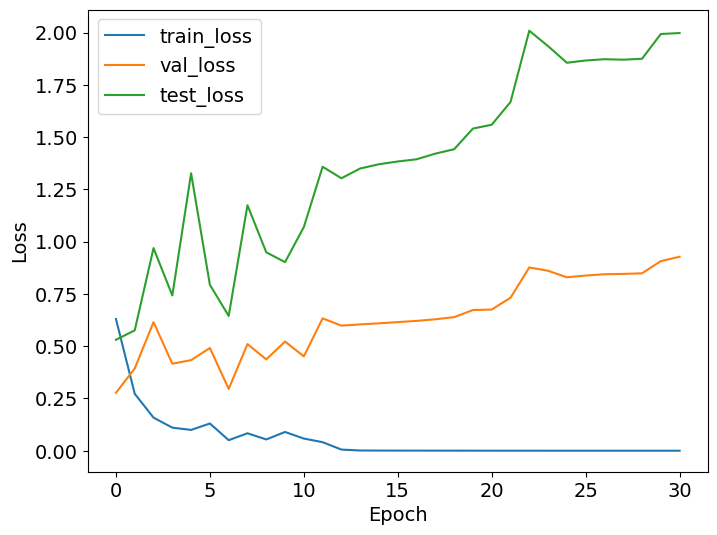

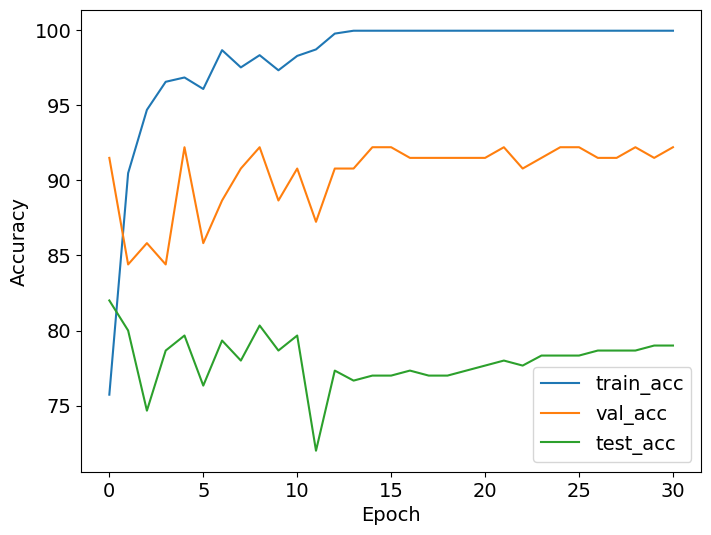

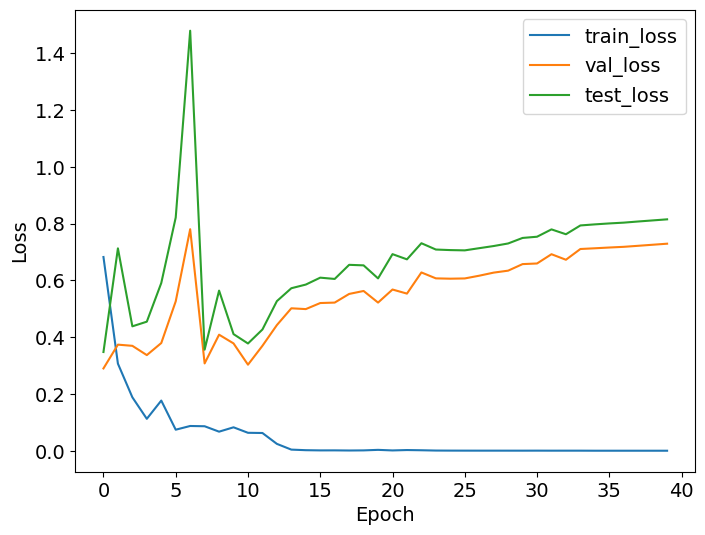

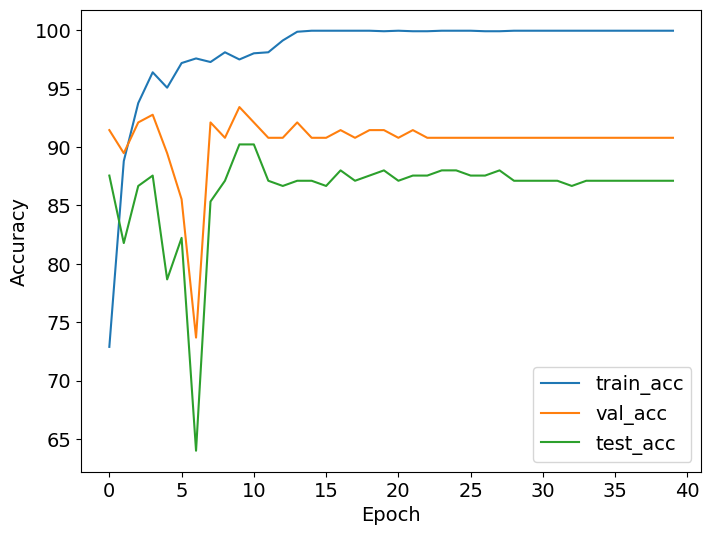

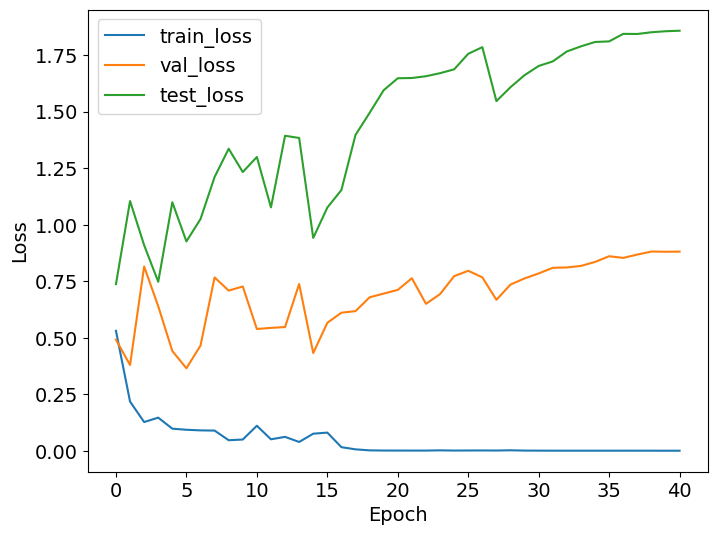

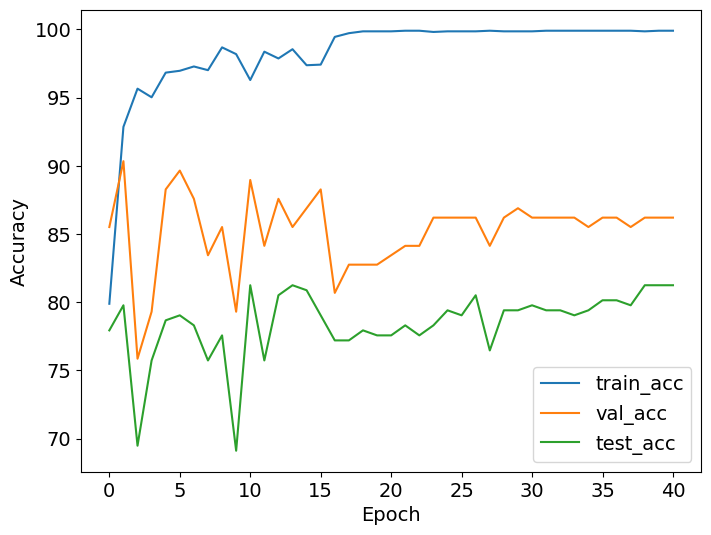

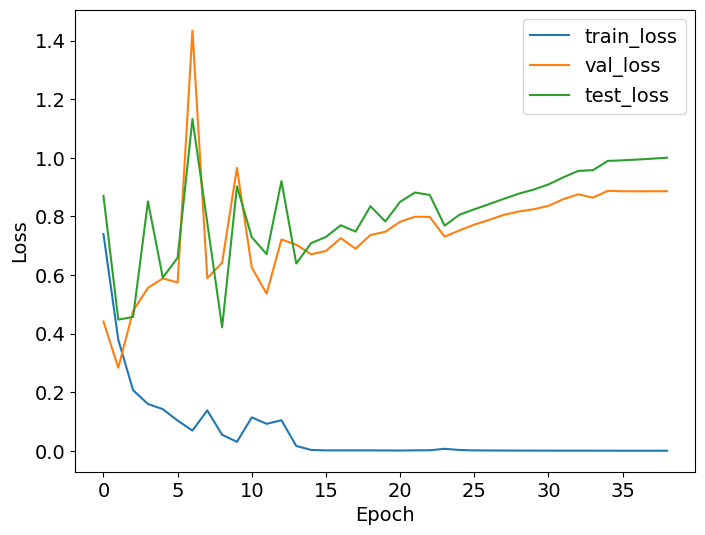

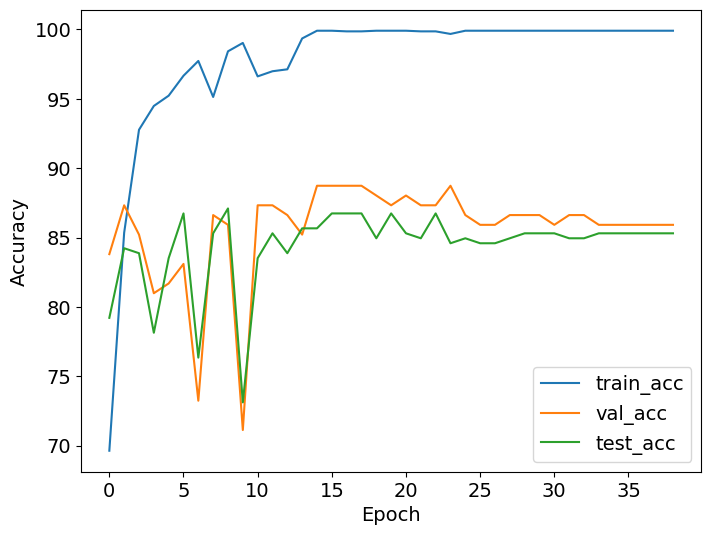

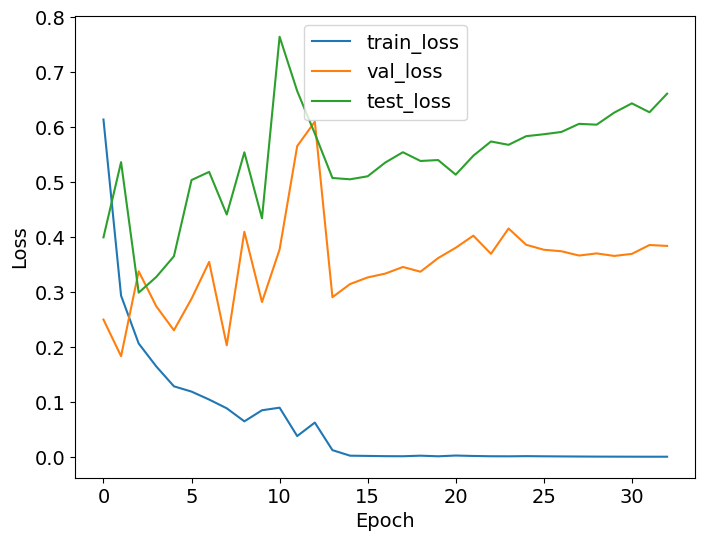

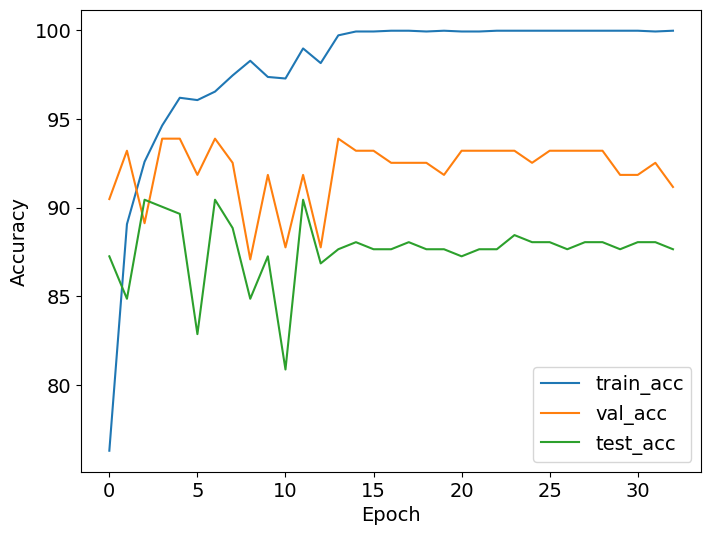

In [4]:
%run -m train

## **Test and Evaluate**







Copy the training results back to GDrive to acesss them later


---

Please note:

1.   **Results are going to be lost when you trun off the current section (Close the tab or leave it for more then 90 mins without any activity)** 
2.   **Make sure that "Results" file is not in your directory to avoid overwriting any existing results**

Test Configurations

In [5]:
%%writefile config_test.py
# CNN test configuration file
config = {}
config['parentdir'] = ''                    # Root directory
# Set to 'True' if you are using ONN
config['ONN'] = False
# 1 for gray scale x-rays, and 3 for RGB (3channel) x-rays
config['input_ch'] = 3
# Batch size, Change to fit hardware
config['batch_size'] = 4
# Number of cross-validation folds
config['num_folds'] = 1
# Confidence interval (missied cases with probability>=CI will be reported in excel file)
config['CI'] = 0.9
# config['input_mean'] = [0.2936]                     # Dataset mean per channel, b/w [0,1]
# config['input_std'] = [0.1895]                      # Dataset std per channel,  b/w [0,1]
# Dataset mean per channel, RGB or RGBA [0,1]
config['input_mean'] = [0.0609,0.0609,0.0609]
# Dataset std per channel,  RGB or RGBA [0,1]
config['input_std'] = [0.1540,0.1540,0.1540]
# 'MSELoss', 'CrossEntropyLoss', etc. (https://pytorch.org/docs/stable/nn.html)
config['loss_func'] = 'CrossEntropyLoss'
# Network input (Image) height
config['Resize_h'] = 224
# Network input (Image) width
config['Resize_w'] = config['Resize_h']
# config['load_weights'] ='/content/gdrive/MyDrive/EthnicData/Results/mobilenet_v2/mobilenet_v2_fold_1.pt'    # specify full path of pretrained model pt file
# Specify path of pretrained model wieghts or set to False to train from scratch
config['load_weights'] = False
# Set to true if you have the labeled test set
config['labeled_Data'] = True
# Required for models with auxilliary outputs (now, only for some custom_CNN models)
config['aux_logits'] = False
# Name of trained model .pt file, same name used in train code
config['model_name'] = 'convnext_xlarge_AHN_Classification'
# Specify a new folder name to save test results
config['new_name'] = 'convnext_xlarge_AHN_Classification'
# Number of steps for inference
config['N_steps'] = 1000
# Define as [] to loop through all folds, or specify start and end folds i.e. [3, 5] or [5, 5]
config['fold_to_run'] = [1,5]
# The destination directory for saving the pipeline outputs (models, results, plots, etc.)
config['outdir'] = ''

Overwriting config_test.py


Evaluate the Test set

Train on GPU: True
1 GPUs detected.
Starting Fold 1...
Loading previously trained model checkpoint...
Model Device: cuda
Combined Evaluation of Folds 1 to 5...


Testing: 100%|██████████| 75/75 [00:11<00:00,  6.63it/s]


Test Loss: 0.5306,  Test Accuracy: 82.0%
Saving Test Results...
Generating CSV Files from Individual Predictions...
Total Inference Time: 5.9e+01 ms
Completed fold 1
Starting Fold 2...
Loading previously trained model checkpoint...
Model Device: cuda
Combined Evaluation of Folds 1 to 5...


Testing: 100%|██████████| 57/57 [00:09<00:00,  5.75it/s]


Test Loss: 0.411,  Test Accuracy: 90.22%
Saving Test Results...
Generating CSV Files from Individual Predictions...
Total Inference Time: 2e+01 ms
Completed fold 2
Starting Fold 3...
Loading previously trained model checkpoint...
Model Device: cuda
Combined Evaluation of Folds 1 to 5...


Testing: 100%|██████████| 68/68 [00:09<00:00,  6.82it/s]


Test Loss: 1.2998,  Test Accuracy: 81.25%
Saving Test Results...
Generating CSV Files from Individual Predictions...
Total Inference Time: 6.1e+01 ms
Completed fold 3
Starting Fold 4...
Loading previously trained model checkpoint...
Model Device: cuda
Combined Evaluation of Folds 1 to 5...


Testing: 100%|██████████| 70/70 [00:10<00:00,  6.45it/s]


Test Loss: 0.4215,  Test Accuracy: 87.1%
Saving Test Results...
Generating CSV Files from Individual Predictions...
Total Inference Time: 5.4e+01 ms
Completed fold 4
Starting Fold 5...
Loading previously trained model checkpoint...
Model Device: cuda
Combined Evaluation of Folds 1 to 5...


Testing: 100%|██████████| 63/63 [00:10<00:00,  6.11it/s]


Test Loss: 0.2993,  Test Accuracy: 90.44%
Saving Test Results...
Generating CSV Files from Individual Predictions...
Total Inference Time: 4.8e+01 ms
Completed fold 5


Combined Evaluation: 100%|██████████| 5/5 [00:08<00:00,  1.75s/it]




Cumulative Confusion Matrix
---------------------------
         SFU_0  SFU_I  SFU_II  SFU_III  SFU_IV
SFU_0      974     22       6        0       0
SFU_I       68     28      25        0       0
SFU_II      30      7      65        4       0
SFU_III      3      0       9       26      11
SFU_IV       0      0       0        2      47


Evaluation Matrices (Overall)
-------------------
                  Accuracy  Precision  Sensitivity  F1_score  Specificity
SFU_0                90.28      90.60        97.21     93.79        68.92
SFU_I                90.81      49.12        23.14     31.46        97.60
SFU_II               93.90      61.90        61.32     61.61        96.72
SFU_III              97.81      81.25        53.06     64.20        99.53
SFU_IV               99.02      81.03        95.92     87.85        99.14
Weighted Average     91.22      83.83        85.91     84.22        76.00
                       
Overall_Accuracy  85.91


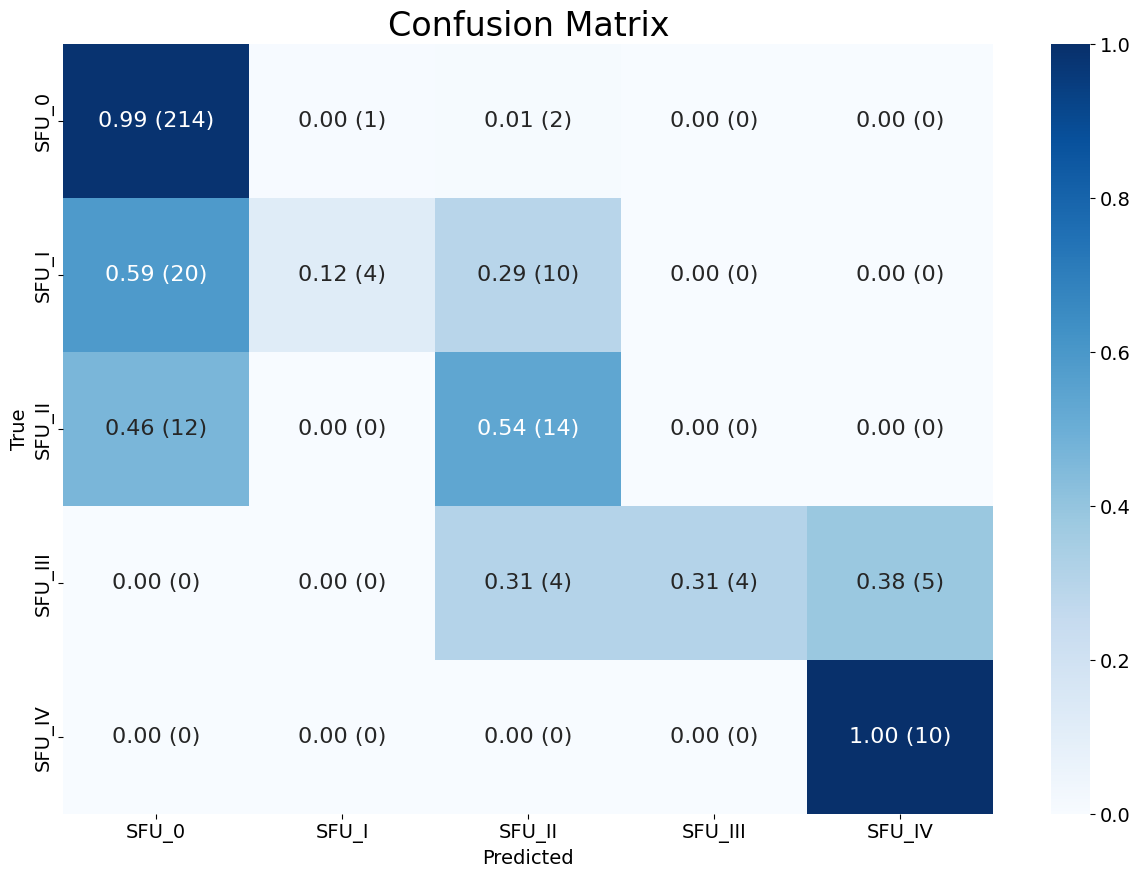

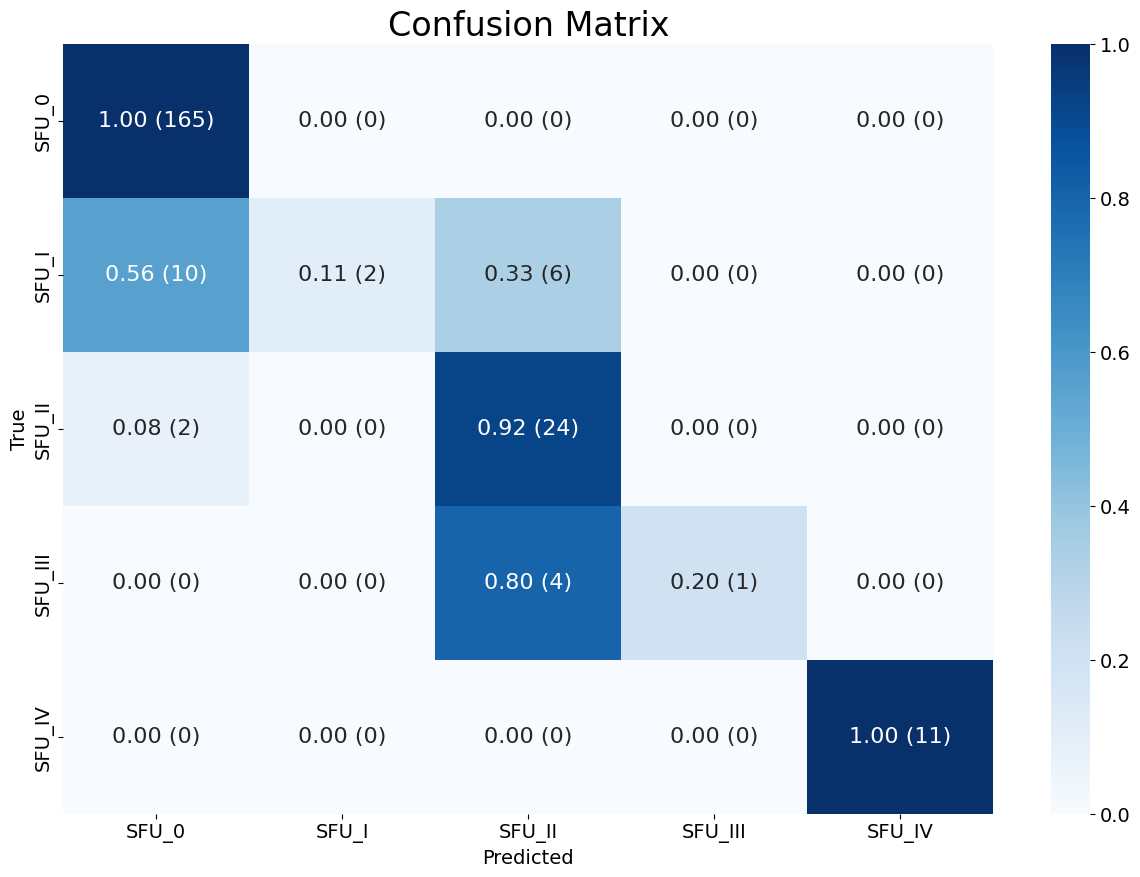

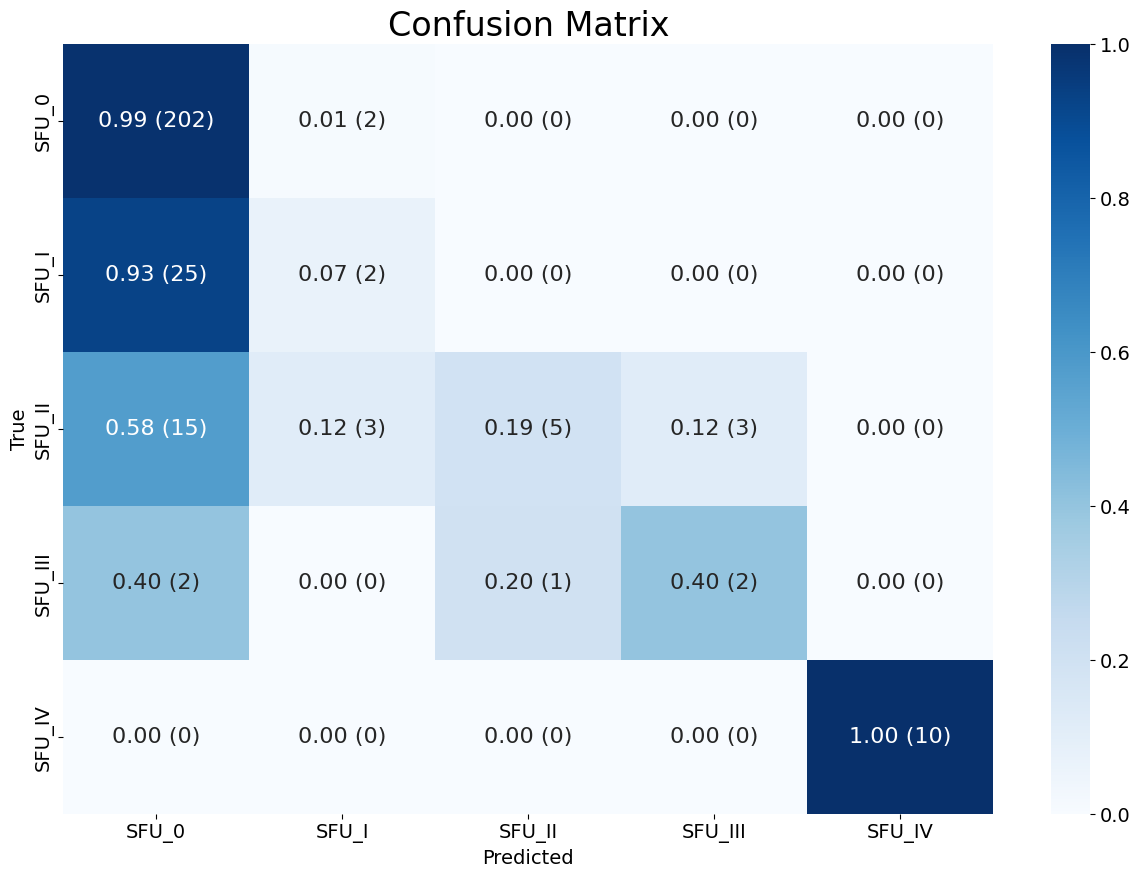

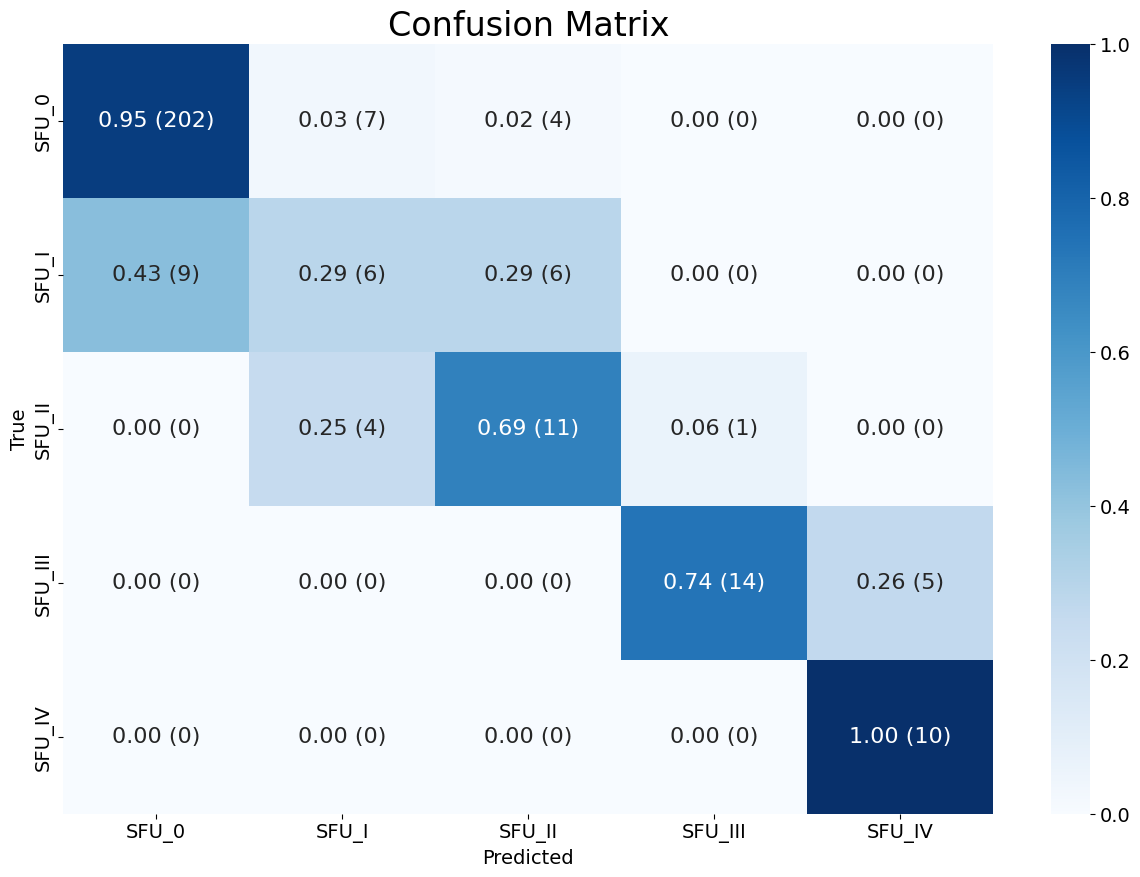

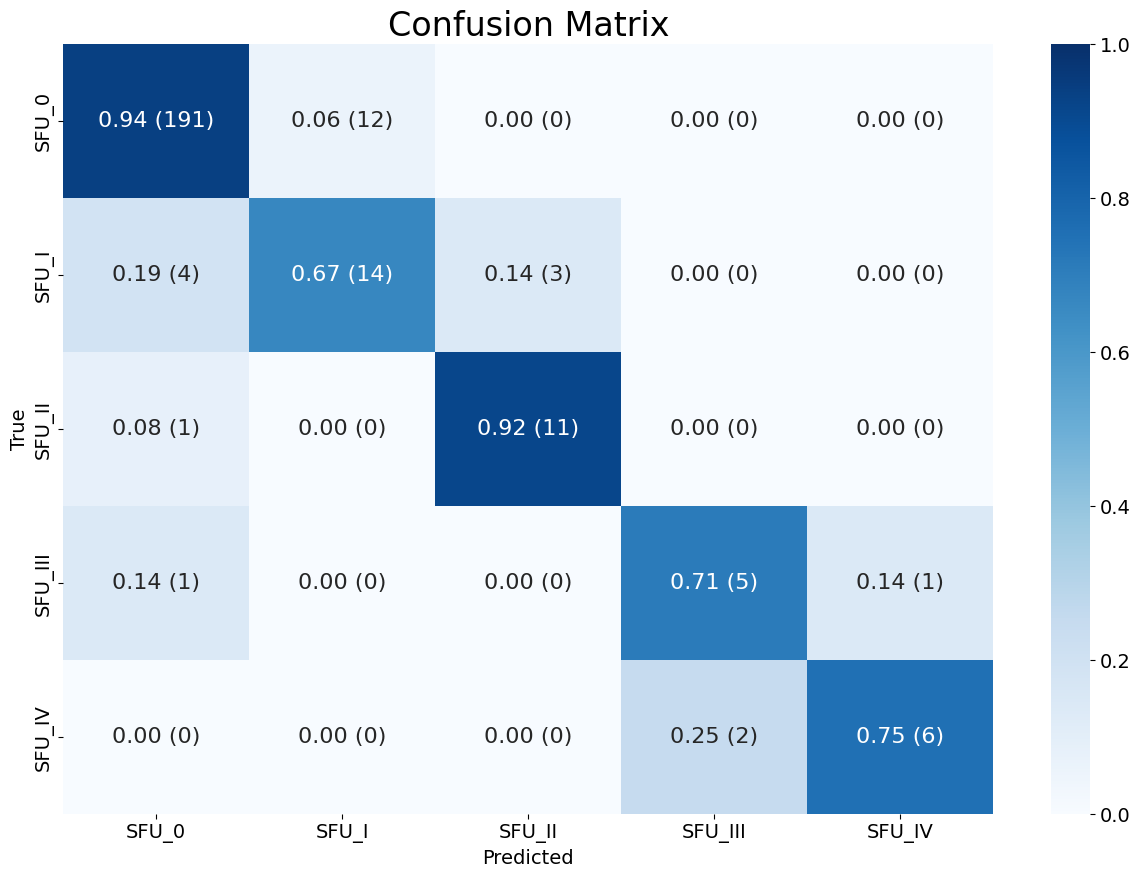

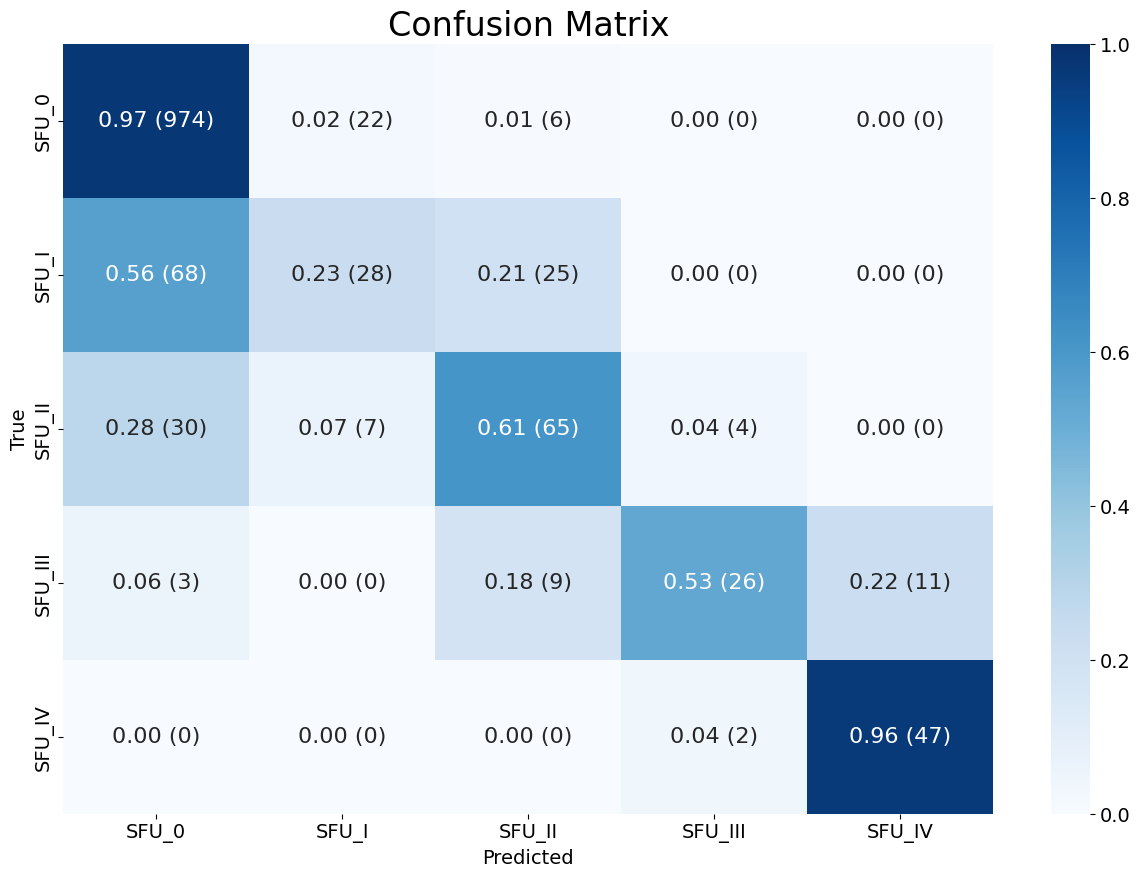

In [6]:
%run -m test

# **CAM**

Import custom functions

In [ ]:
from CAM.imagenet_labels import label2idx, idx2label
from CAM.visualize import visualize, reverse_normalize
from CAM.cam_functions import CAM, GradCAM, GradCAMpp, SmoothGradCAMpp, ScoreCAM
%matplotlib inline


Import and process image

In [ ]:
# preprocessing. mean and std from ImageNet
normalize = transforms.Normalize(mean=[0.2060, 0.2060, 0.2060],
                                 std=[0.1856, 0.1856, 0.1856]
                                 )

preprocess = transforms.Compose([
    transforms.ToTensor(),
    normalize
])


In [ ]:
image_path = '/content/Data/Test/fold_1/SFU4/90_2.png'
image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
# image = cv2.resize(image, (512,512), interpolation = cv2.INTER_CUBIC)  # Resize image
imshow(image)
tensor = preprocess(image)  # convert image to tensor
tensor = tensor.unsqueeze(0)  # reshape 4D tensor (N, C, H, W)
print(tensor.size())


Import Model and Extract Target Layer

In [ ]:
model_path = '/content/gdrive/MyDrive/Colab_Notebooks/Research/Kidney_AHN_Thesis_Task/HN_Multiclass_Classification/Results/MobileNetV2_HN_Classification/fold_1/MobileNetV2_HN_Classification_fold_1.pt'
checkpoint = torch.load(model_path)
model = checkpoint['model']
model.eval()


In [ ]:
target_layer = model.features[18]
target_layer = target_layer[0]
print(target_layer)


Create Warapper Model for CAM

In [ ]:
# Configuration - Choose CAM Type
# Current Options: 'CAM', 'GradCAM', 'GradCAM++', 'SmoothGradCAM++', 'ScoreCAM
wrapper_model_type = 'ScoreCAM'
tensor = tensor.to('cpu')
model = model.to('cpu')


In [ ]:
wrapper_model = []
if wrapper_model_type == 'CAM':
    wrapper_model = CAM(model, target_layer)
elif wrapper_model_type == 'GradCAM':
    wrapper_model = GradCAM(model, target_layer)
elif wrapper_model_type == 'GradCAM++':
    wrapper_model = GradCAMpp(model, target_layer)
elif wrapper_model_type == 'SmoothGradCAM++':
    wrapper_model = SmoothGradCAMpp(
        model, target_layer, n_samples=25, stdev_spread=0.15)
elif wrapper_model_type == 'ScoreCAM':
    tensor = tensor.to('cuda')
    model = model.to('cuda')
    wrapper_model = ScoreCAM(model, target_layer)


Plot and Save CAM Heatmap

In [ ]:
cam, idx = wrapper_model(tensor)
print(idx2label[idx])
imshow(cam.squeeze().numpy(), alpha=0.5, cmap='jet')  # Visualize only cam


In [ ]:
# reverse normalization for display
img = reverse_normalize(tensor)
heatmap = visualize(img, cam)
save_image(heatmap, 'cam_output.png'.format(
    idx2label[idx]).replace(" ", "_").replace(",", ""))


# **Move Files to and fro GDrive**

## Copy Experiment Results from Virtual Machine or VM (Contents) to a Google Drive Folder

In [ ]:
!cp - av '/content/Results/' '/content/GDrive/MyDrive/'


## Copy Documents from a Google Drive Folder to VM (Contents)

In [ ]:
!cp - av '/content/GDrive/MyDrive/Research/Kidney_AHN_Segmentation/Results' '/content'


## Remove non-empty Directory from the VM

In [ ]:
import shutil
shutil.rmtree('/content/Data')


# **Infinite Loop**

In [ ]:
while True:
    pass
